In [1]:
import os
import sys
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from PIL import Image
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms

import argparse
from collections import deque



In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [24]:
# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Dataset class
class SpectrogramDataset(Dataset):
    def __init__(self, root_dir, folds, csv_file, transform=None, use_augmentations=True):
        self.root_dir = root_dir
        self.transform = transform
        self.use_augmentations = use_augmentations

        # Read the CSV file with the spectrogram information
        self.annotations = pd.read_csv(csv_file)

        # Handle single or multiple folds
        if isinstance(folds, int):
            folds = [folds]

        # Filter by folds
        self.file_list = self.annotations[self.annotations['fold'].isin(folds)]

        # Filter out augmentations if specified
        if not use_augmentations:
            self.file_list = self.file_list[self.file_list['augmentation'] == 'original']

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        # Get the file path
        img_name = self.file_list.iloc[idx]['spec_file_name']
        fold = self.file_list.iloc[idx]['fold']
        label = self.file_list.iloc[idx]['classID']

        # Construct the full path to the image
        img_path = os.path.join(self.root_dir, f'fold{fold}', img_name)

        # Load the image
        image = Image.open(img_path).convert('RGB')

        # Apply transformations if provided
        if self.transform:
            if self.use_augmentations:
                # For MoCo, we need two differently augmented views of the same image
                q = self.transform(image)  # query
                k = self.transform(image)  # key
                return q, k, label
            else:
                # Always apply transform for validation
                image = self.transform(image)

        return image, label

# MLP for projection head
class ProjectionHead(nn.Module):
    def __init__(self, input_dim=2048, hidden_dim=2048, output_dim=128):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
      return self.layers(x)
def mixup_data(x1, x2, y1, y2, alpha=0.4):

    # Sample lambda from a beta distribution
    lambda_ = torch.distributions.Beta(alpha, alpha).sample().item()

    # Mix the images and labels
    mixed_x = lambda_ * x1 + (1 - lambda_) * x2
    mixed_y = lambda_ * y1 + (1 - lambda_) * y2

    return mixed_x, mixed_y, lambda_

def train_with_mixup(moco, contrastive_criterion, im_q, im_k, labels, alpha=0.4):
    """
    MoCo training with MixUp on query and key images.

    Args:
    - moco: MoCo model
    - contrastive_criterion: Loss function
    - im_q: Query image batch
    - im_k: Key image batch
    - labels: Ground truth labels
    - alpha: MixUp hyperparameter

    Returns:
    - moco_loss: Loss value after applying MixUp
    """
    # Apply MixUp to the query and key images, and their labels
    im_q, labels_q, lambda_q = mixup_data(im_q, im_k, labels, labels, alpha)
    im_k, labels_k, lambda_k = mixup_data(im_k, im_q, labels, labels, alpha)

    # Forward pass through the MoCo model
    logits, targets, q_feat = moco(im_q, im_k)

    # Compute the MoCo contrastive loss (similar to how it's done normally)
    moco_loss = contrastive_criterion(logits, targets)

    # Optionally, you can also apply the weighted loss based on lambda
    # Note: MoCo loss typically uses a contrastive approach, so this is optional
    moco_loss = lambda_q * moco_loss

    return moco_loss

# MoCo model components
class MoCo(nn.Module):
    def __init__(self, backbone=None, dim=128, K=4096, m=0.999, T=0.07):
        super().__init__()
        """
        backbone: base encoder network (default: ResNet50)
        dim: feature dimension (default: 128)
        K: queue size (default: 4096)
        m: moco momentum of updating key encoder (default: 0.999)
        T: softmax temperature (default: 0.07)
        """
        self.K = K
        self.m = m
        self.T = T

        # Create backbone if not provided
        if backbone is None:
            backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
            backbone.fc = nn.Identity()  # Remove classification layer

        # Create encoder q (online network)
        self.encoder_q = backbone
        self.projection_q = ProjectionHead(input_dim=2048, output_dim=dim)

        # Create encoder k (momentum network) - no gradient
        self.encoder_k = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.encoder_k.fc = nn.Identity()
        self.projection_k = ProjectionHead(input_dim=2048, output_dim=dim)

        # Initialize the momentum network with the same parameters
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data.copy_(param_q.data)
            param_k.requires_grad = False

        for param_q, param_k in zip(self.projection_q.parameters(), self.projection_k.parameters()):
            param_k.data.copy_(param_q.data)
            param_k.requires_grad = False

        # Create the queue for negative samples
        self.register_buffer("queue", torch.randn(dim, K))
        self.queue = F.normalize(self.queue, dim=0)
        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))

    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        """Momentum update of the key encoder"""
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1. - self.m)

        for param_q, param_k in zip(self.projection_q.parameters(), self.projection_k.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1. - self.m)

    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
        batch_size = keys.shape[0]

        ptr = int(self.queue_ptr)
        # Handle case where batch size doesn't divide queue size evenly
        if ptr + batch_size > self.K:
            # Split the batch to avoid overflow
            first_part = self.K - ptr
            self.queue[:, ptr:] = keys[:first_part].T
            self.queue[:, :batch_size-first_part] = keys[first_part:].T
            ptr = (batch_size - first_part) % self.K
        else:
            # Replace the keys at ptr (dequeue and enqueue)
            self.queue[:, ptr:ptr + batch_size] = keys.T
            ptr = (ptr + batch_size) % self.K  # move pointer

        self.queue_ptr[0] = ptr

    @torch.no_grad()
    def get_features(self, x):
        """Get features from the encoder_q for downstream tasks"""
        return self.encoder_q(x)

    def forward(self, im_q, im_k=None, get_features=False):
        """Forward pass for MoCo

        Args:
            im_q: a batch of query images
            im_k: a batch of key images (if None, only return features)
            get_features: if True, return features instead of contrastive loss
        """
        # Extract features for downstream tasks if requested
        if get_features:
            return self.get_features(im_q)

        # Compute query features
        q = self.encoder_q(im_q)  # queries: NxC
        q_proj = self.projection_q(q)  # projects: NxD
        q_proj = F.normalize(q_proj, dim=1)  # normalize

        # Compute key features
        with torch.no_grad():  # no gradient to keys
            self._momentum_update_key_encoder()  # update the key encoder

            k = self.encoder_k(im_k)  # keys: NxC
            k_proj = self.projection_k(k)  # projects: NxD
            k_proj = F.normalize(k_proj, dim=1)  # normalize

        # Compute logits
        # positive logits: Nx1
        l_pos = torch.einsum('nc,nc->n', [q_proj, k_proj]).unsqueeze(-1)
        # negative logits: NxK
        l_neg = torch.einsum('nc,ck->nk', [q_proj, self.queue.clone().detach()])

        # logits: Nx(1+K)
        logits = torch.cat([l_pos, l_neg], dim=1)

        # apply temperature
        logits /= self.T

        # labels: positives are the 0th position
        labels = torch.zeros(logits.shape[0], dtype=torch.long, device=logits.device)

        # Dequeue and enqueue
        self._dequeue_and_enqueue(k_proj)

        return logits, labels, q

# Classifier for downstream task
class Classifier(nn.Module):
    def __init__(self, input_dim=2048, num_classes=14):
        super().__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)


# Training function
def train(fold, class_names, num_classes, batch_size=64, num_epochs=30, alpha=0.2):
    """
    Train the MoCo model with MixUp augmentation.

    Args:
        fold: Fold number to use as validation
        class_names: List of class names
        num_classes: Number of classes
        batch_size: Batch size
        num_epochs: Number of epochs
        alpha: MixUp parameter for Beta distribution
    """
    # Create timestamp for saving results
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    results_dir = f"results_moco_{timestamp}"
    os.makedirs(results_dir, exist_ok=True)
    print(f"Results will be saved to {results_dir}")

    # Set up device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Define transformations for training
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([transforms.ColorJitter(0.8, 0.8, 0.8, 0.2)], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Define transformations for validation (no augmentation)
    eval_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Data loaders
    train_folds = [f for f in range(1, 11) if f != fold]

    train_ds = SpectrogramDataset(
        './spectrograms',
        train_folds,
        './spectrograms_balanced.csv',
        transform,
        use_augmentations=True
    )

    val_ds = SpectrogramDataset(
        './spectrograms',
        [fold],
        './spectrograms_balanced.csv',
        eval_transform,
        use_augmentations=False
    )

    # Ensure batch size is compatible with queue size (for simplicity)
    moco_K = 4096  # Queue size
    if moco_K % batch_size != 0:
        new_batch_size = batch_size
        while moco_K % new_batch_size != 0:
            new_batch_size -= 1
        print(f"Adjusting batch size from {batch_size} to {new_batch_size} to be compatible with queue size {moco_K}")
        batch_size = new_batch_size

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)

    # Initialize models
    backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    backbone.fc = nn.Identity()

    moco = MoCo(backbone, K=moco_K).to(device)
    classifier = Classifier(input_dim=2048, num_classes=num_classes).to(device)

    # Optimizer
    optimizer = torch.optim.Adam(
        list(moco.parameters()) + list(classifier.parameters()),
        lr=3e-4
    )

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=num_epochs
    )

    # Classification loss
    classification_criterion = torch.nn.CrossEntropyLoss()
    contrastive_criterion = torch.nn.CrossEntropyLoss()

    # Metrics storage
    train_losses, val_losses = [], []
    val_accuracies, all_preds, all_labels = [], [], []

    for epoch in range(num_epochs):
        # TRAINING
        moco.train()
        classifier.train()
        epoch_train_loss = 0.0

        for batch_idx, (im_q, im_k, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            im_q, im_k, labels = im_q.to(device), im_k.to(device), labels.to(device)

            # Apply MixUp to the spectrogram inputs and labels
            loss = train_with_mixup(moco, contrastive_criterion, im_q, im_k, labels, alpha=0.02)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass for MoCo with MixUp
            logits, targets, q_feat = moco(im_q, im_k)

            # MoCo contrastive loss
            moco_loss = contrastive_criterion(logits, targets)

            # Classification loss (using mixed features)
            with torch.no_grad():
                features = moco.get_features(im_q)

            logits_cls = classifier(features.detach())
            cls_loss = classification_criterion(logits_cls, labels)

            # Total loss
            loss = moco_loss + cls_loss

            # Backward pass
            loss.backward()

            # Update parameters
            optimizer.step()

            # Track metrics
            epoch_train_loss += loss.item() * im_q.size(0)

            # Report training progress
            if batch_idx % 10 == 0:
                print(f"  Batch {batch_idx}/{len(train_loader)}, "
                      f"MoCo Loss: {moco_loss.item():.4f}, "
                      f"Cls Loss: {cls_loss.item():.4f}, "
                      f"Total Loss: {loss.item():.4f}")

        # Calculate average training loss
        epoch_train_loss /= len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # VALIDATION
        moco.eval()
        classifier.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        epoch_preds = []
        epoch_labels = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                # Extract features
                features = moco.get_features(images)

                # Make predictions
                logits = classifier(features)
                loss = classification_criterion(logits, labels)

                # Track metrics
                val_loss += loss.item() * images.size(0)

                # Calculate accuracy
                _, predictions = torch.max(logits, 1)
                total += labels.size(0)
                correct += (predictions == labels).sum().item()

                # Store predictions and labels for confusion matrix
                epoch_preds.extend(predictions.cpu().numpy())
                epoch_labels.extend(labels.cpu().numpy())

        # Calculate validation metrics
        val_loss /= len(val_loader.dataset)
        val_accuracy = 100.0 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        all_preds.append(epoch_preds)
        all_labels.append(epoch_labels)

        # Update learning rate
        scheduler.step()

        # Report epoch results
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {epoch_train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val Accuracy: {val_accuracy:.2f}%")

        # Save model checkpoint
        torch.save({
            'epoch': epoch,
            'moco': moco.state_dict(),
            'classifier': classifier.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'train_loss': epoch_train_loss,
            'val_loss': val_loss,
            'val_accuracy': val_accuracy
        }, f"{results_dir}/checkpoint_{epoch}.pth")

    # Save the final model
    torch.save({
        'moco': moco.state_dict(),
        'classifier': classifier.state_dict(),
        'val_accuracy': val_accuracies[-1],
        'class_names': class_names
    }, f"{results_dir}/fold_{fold}_model.pth")

    # Save loss and accuracy plots
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), train_losses, 'b-', label='Training Loss')
    plt.plot(range(1, num_epochs+1), val_losses, 'r-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Loss Curve for Fold {fold}')

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), val_accuracies, 'g-')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy (%)')
    plt.title(f'Accuracy Curve for Fold {fold}')

    plt.tight_layout()
    plt.savefig(f"{results_dir}/fold_{fold}_plots.png")

    # Generate confusion matrix for the final epoch
    final_cm = confusion_matrix(all_labels[-1], all_preds[-1])
    plt.figure(figsize=(10, 8))
    sns.heatmap(final_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for Fold {fold}')
    plt.tight_layout()
    plt.savefig(f"{results_dir}/fold_{fold}_confusion_matrix.png")

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels[-1], all_preds[-1], target_names=class_names))


def main(spec_csv, batch_size, epochs):
    """
    # Main function to start the training
    # """
    # parser = argparse.ArgumentParser(description='Train MoCo on spectrograms')
    # parser.add_argument('--fold', type=int, help='Fold to use as validation (1-10)', required=False)
    # parser.add_argument('--debug', action='store_true', help='Enable anomaly detection for debugging')
    # parser.add_argument('--batch_size', type=int, default=32, help='Batch size')
    # parser.add_argument('--epochs', type=int, default=30, help='Number of epochs')
    # args = parser.parse_args()

    # Enable anomaly detection if requested
    # if args.debug:
    #     print("Enabling anomaly detection for debugging")
    #     torch.autograd.set_detect_anomaly(True)

    # Set random seed
    set_seed(42)

    # Get class names and auto-detect num_classes
    print("Loading data from ./spectrograms_balanced.csv")
    full_annotations =spec_csv
    class_names = sorted(full_annotations['class'].unique())
    num_classes = len(class_names)
    print(f"Detected {num_classes} classes: {class_names}")

    num_folds = 10

    # # Train specific fold or all folds
    # if args.fold is not None:
    #     # Train only the specified fold
    #     fold = args.fold
    # print(f"\n=== Training Fold {fold}/{num_folds} ===")
    # train(fold, class_names, num_classes, args.debug, args.batch_size, args.epochs)
    #     # Train all folds one by one
    all_fold_accuracies = []

    for fold in range(1, num_folds+1):
      print(f"\n=== Training Fold {fold}/{num_folds} ===")

            # Clear GPU cache to prevent memory buildup between folds
    if torch.cuda.is_available():
      torch.cuda.empty_cache()

    accuracy = train(fold, class_names, num_classes, batch_size, epochs)
    all_fold_accuracies.append(accuracy)

    # Report average accuracy
    avg_accuracy = np.mean(all_fold_accuracies)
    print(f"\nAverage accuracy across {num_folds} folds: {avg_accuracy:.2f}%")



Loading data from ./spectrograms_balanced.csv
Detected 13 classes: ['air_conditioner', 'ambulance', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'firetruck', 'gun_shot', 'jackhammer', 'police', 'street_music', 'traffic']

=== Training Fold 1/10 ===

=== Training Fold 2/10 ===

=== Training Fold 3/10 ===

=== Training Fold 4/10 ===

=== Training Fold 5/10 ===

=== Training Fold 6/10 ===

=== Training Fold 7/10 ===

=== Training Fold 8/10 ===

=== Training Fold 9/10 ===

=== Training Fold 10/10 ===
Results will be saved to results_moco_20250404_151233
Using device: cuda:0


Epoch 1/5:   0%|          | 1/654 [00:02<27:13,  2.50s/it]

  Batch 0/654, MoCo Loss: 3.8569, Cls Loss: 2.6773, Total Loss: 6.5342


Epoch 1/5:   2%|▏         | 11/654 [00:27<26:53,  2.51s/it]

  Batch 10/654, MoCo Loss: 6.7738, Cls Loss: 2.5428, Total Loss: 9.3166


Epoch 1/5:   3%|▎         | 21/654 [00:52<26:04,  2.47s/it]

  Batch 20/654, MoCo Loss: 6.9224, Cls Loss: 2.3616, Total Loss: 9.2840


Epoch 1/5:   5%|▍         | 31/654 [01:17<25:41,  2.47s/it]

  Batch 30/654, MoCo Loss: 6.5958, Cls Loss: 2.1830, Total Loss: 8.7788


Epoch 1/5:   6%|▋         | 41/654 [01:42<25:48,  2.53s/it]

  Batch 40/654, MoCo Loss: 6.3760, Cls Loss: 2.1441, Total Loss: 8.5201


Epoch 1/5:   8%|▊         | 51/654 [02:07<25:06,  2.50s/it]

  Batch 50/654, MoCo Loss: 6.4307, Cls Loss: 2.2340, Total Loss: 8.6647


Epoch 1/5:   9%|▉         | 61/654 [02:32<24:49,  2.51s/it]

  Batch 60/654, MoCo Loss: 6.0093, Cls Loss: 1.8070, Total Loss: 7.8163


Epoch 1/5:  11%|█         | 71/654 [02:56<24:02,  2.47s/it]

  Batch 70/654, MoCo Loss: 6.4457, Cls Loss: 1.9967, Total Loss: 8.4424


Epoch 1/5:  12%|█▏        | 81/654 [03:21<23:44,  2.49s/it]

  Batch 80/654, MoCo Loss: 6.5764, Cls Loss: 2.2205, Total Loss: 8.7969


Epoch 1/5:  14%|█▍        | 91/654 [03:46<23:35,  2.51s/it]

  Batch 90/654, MoCo Loss: 6.2970, Cls Loss: 1.8758, Total Loss: 8.1728


Epoch 1/5:  15%|█▌        | 101/654 [04:11<22:48,  2.48s/it]

  Batch 100/654, MoCo Loss: 5.8423, Cls Loss: 1.9346, Total Loss: 7.7769


Epoch 1/5:  17%|█▋        | 111/654 [04:36<22:31,  2.49s/it]

  Batch 110/654, MoCo Loss: 5.8488, Cls Loss: 1.6992, Total Loss: 7.5480


Epoch 1/5:  19%|█▊        | 121/654 [05:01<22:02,  2.48s/it]

  Batch 120/654, MoCo Loss: 5.8514, Cls Loss: 1.6372, Total Loss: 7.4886


Epoch 1/5:  20%|██        | 131/654 [05:26<21:33,  2.47s/it]

  Batch 130/654, MoCo Loss: 5.6073, Cls Loss: 1.6852, Total Loss: 7.2925


Epoch 1/5:  22%|██▏       | 141/654 [05:51<21:10,  2.48s/it]

  Batch 140/654, MoCo Loss: 5.5118, Cls Loss: 1.5264, Total Loss: 7.0382


Epoch 1/5:  23%|██▎       | 151/654 [06:15<20:41,  2.47s/it]

  Batch 150/654, MoCo Loss: 5.6415, Cls Loss: 1.7187, Total Loss: 7.3603


Epoch 1/5:  25%|██▍       | 161/654 [06:40<20:23,  2.48s/it]

  Batch 160/654, MoCo Loss: 5.9061, Cls Loss: 1.7689, Total Loss: 7.6750


Epoch 1/5:  26%|██▌       | 171/654 [07:05<19:52,  2.47s/it]

  Batch 170/654, MoCo Loss: 5.7117, Cls Loss: 1.7175, Total Loss: 7.4292


Epoch 1/5:  28%|██▊       | 181/654 [07:30<19:38,  2.49s/it]

  Batch 180/654, MoCo Loss: 5.5904, Cls Loss: 1.6392, Total Loss: 7.2296


Epoch 1/5:  29%|██▉       | 191/654 [07:55<19:08,  2.48s/it]

  Batch 190/654, MoCo Loss: 5.7672, Cls Loss: 1.8127, Total Loss: 7.5799


Epoch 1/5:  31%|███       | 201/654 [08:19<18:43,  2.48s/it]

  Batch 200/654, MoCo Loss: 5.4988, Cls Loss: 1.7137, Total Loss: 7.2124


Epoch 1/5:  32%|███▏      | 211/654 [08:45<18:29,  2.50s/it]

  Batch 210/654, MoCo Loss: 5.3899, Cls Loss: 1.5399, Total Loss: 6.9299


Epoch 1/5:  34%|███▍      | 221/654 [09:10<18:09,  2.52s/it]

  Batch 220/654, MoCo Loss: 5.6393, Cls Loss: 1.5914, Total Loss: 7.2306


Epoch 1/5:  35%|███▌      | 231/654 [09:35<17:29,  2.48s/it]

  Batch 230/654, MoCo Loss: 5.6246, Cls Loss: 1.8244, Total Loss: 7.4490


Epoch 1/5:  37%|███▋      | 241/654 [09:59<17:08,  2.49s/it]

  Batch 240/654, MoCo Loss: 5.4359, Cls Loss: 1.6251, Total Loss: 7.0610


Epoch 1/5:  38%|███▊      | 251/654 [10:24<16:36,  2.47s/it]

  Batch 250/654, MoCo Loss: 5.3148, Cls Loss: 1.5833, Total Loss: 6.8982


Epoch 1/5:  40%|███▉      | 261/654 [10:49<16:21,  2.50s/it]

  Batch 260/654, MoCo Loss: 5.1765, Cls Loss: 1.4609, Total Loss: 6.6374


Epoch 1/5:  41%|████▏     | 271/654 [11:14<15:58,  2.50s/it]

  Batch 270/654, MoCo Loss: 5.5796, Cls Loss: 1.5173, Total Loss: 7.0970


Epoch 1/5:  43%|████▎     | 281/654 [11:39<15:26,  2.49s/it]

  Batch 280/654, MoCo Loss: 5.8414, Cls Loss: 1.6243, Total Loss: 7.4657


Epoch 1/5:  44%|████▍     | 291/654 [12:04<15:01,  2.48s/it]

  Batch 290/654, MoCo Loss: 5.5072, Cls Loss: 1.8151, Total Loss: 7.3223


Epoch 1/5:  46%|████▌     | 301/654 [12:28<14:31,  2.47s/it]

  Batch 300/654, MoCo Loss: 5.4399, Cls Loss: 1.5087, Total Loss: 6.9486


Epoch 1/5:  48%|████▊     | 311/654 [12:53<14:11,  2.48s/it]

  Batch 310/654, MoCo Loss: 5.4215, Cls Loss: 1.3915, Total Loss: 6.8130


Epoch 1/5:  49%|████▉     | 321/654 [13:18<13:52,  2.50s/it]

  Batch 320/654, MoCo Loss: 5.0106, Cls Loss: 1.5023, Total Loss: 6.5129


Epoch 1/5:  51%|█████     | 331/654 [13:43<13:20,  2.48s/it]

  Batch 330/654, MoCo Loss: 5.2304, Cls Loss: 1.6897, Total Loss: 6.9201


Epoch 1/5:  52%|█████▏    | 341/654 [14:08<12:54,  2.48s/it]

  Batch 340/654, MoCo Loss: 5.5787, Cls Loss: 1.4064, Total Loss: 6.9851


Epoch 1/5:  54%|█████▎    | 351/654 [14:33<12:36,  2.50s/it]

  Batch 350/654, MoCo Loss: 5.3613, Cls Loss: 1.5164, Total Loss: 6.8777


Epoch 1/5:  55%|█████▌    | 361/654 [14:58<12:09,  2.49s/it]

  Batch 360/654, MoCo Loss: 5.0500, Cls Loss: 1.3206, Total Loss: 6.3706


Epoch 1/5:  57%|█████▋    | 371/654 [15:23<11:45,  2.49s/it]

  Batch 370/654, MoCo Loss: 5.0287, Cls Loss: 1.5345, Total Loss: 6.5633


Epoch 1/5:  58%|█████▊    | 381/654 [15:48<11:16,  2.48s/it]

  Batch 380/654, MoCo Loss: 5.1527, Cls Loss: 1.3164, Total Loss: 6.4691


Epoch 1/5:  60%|█████▉    | 391/654 [16:13<10:52,  2.48s/it]

  Batch 390/654, MoCo Loss: 5.0722, Cls Loss: 1.2308, Total Loss: 6.3031


Epoch 1/5:  61%|██████▏   | 401/654 [16:37<10:23,  2.46s/it]

  Batch 400/654, MoCo Loss: 5.0329, Cls Loss: 1.2588, Total Loss: 6.2917


Epoch 1/5:  63%|██████▎   | 411/654 [17:02<10:00,  2.47s/it]

  Batch 410/654, MoCo Loss: 5.0793, Cls Loss: 1.3189, Total Loss: 6.3982


Epoch 1/5:  64%|██████▍   | 421/654 [17:27<09:36,  2.47s/it]

  Batch 420/654, MoCo Loss: 4.8701, Cls Loss: 1.4320, Total Loss: 6.3020


Epoch 1/5:  66%|██████▌   | 431/654 [17:52<09:10,  2.47s/it]

  Batch 430/654, MoCo Loss: 5.1565, Cls Loss: 1.3253, Total Loss: 6.4818


Epoch 1/5:  67%|██████▋   | 441/654 [18:17<08:54,  2.51s/it]

  Batch 440/654, MoCo Loss: 4.9360, Cls Loss: 1.5701, Total Loss: 6.5061


Epoch 1/5:  69%|██████▉   | 451/654 [18:41<08:23,  2.48s/it]

  Batch 450/654, MoCo Loss: 4.9306, Cls Loss: 1.3328, Total Loss: 6.2634


Epoch 1/5:  70%|███████   | 461/654 [19:06<07:59,  2.48s/it]

  Batch 460/654, MoCo Loss: 4.8101, Cls Loss: 1.3255, Total Loss: 6.1355


Epoch 1/5:  72%|███████▏  | 471/654 [19:31<07:36,  2.49s/it]

  Batch 470/654, MoCo Loss: 5.0687, Cls Loss: 1.3942, Total Loss: 6.4630


Epoch 1/5:  74%|███████▎  | 481/654 [19:56<07:12,  2.50s/it]

  Batch 480/654, MoCo Loss: 5.2658, Cls Loss: 1.3277, Total Loss: 6.5934


Epoch 1/5:  75%|███████▌  | 491/654 [20:21<06:41,  2.46s/it]

  Batch 490/654, MoCo Loss: 5.6537, Cls Loss: 1.5171, Total Loss: 7.1708


Epoch 1/5:  77%|███████▋  | 501/654 [20:46<06:19,  2.48s/it]

  Batch 500/654, MoCo Loss: 4.8024, Cls Loss: 1.2736, Total Loss: 6.0760


Epoch 1/5:  78%|███████▊  | 511/654 [21:11<05:56,  2.49s/it]

  Batch 510/654, MoCo Loss: 5.1560, Cls Loss: 1.4653, Total Loss: 6.6214


Epoch 1/5:  80%|███████▉  | 521/654 [21:35<05:30,  2.48s/it]

  Batch 520/654, MoCo Loss: 5.3409, Cls Loss: 1.3214, Total Loss: 6.6622


Epoch 1/5:  81%|████████  | 531/654 [22:00<05:05,  2.48s/it]

  Batch 530/654, MoCo Loss: 5.1826, Cls Loss: 1.5107, Total Loss: 6.6933


Epoch 1/5:  83%|████████▎ | 541/654 [22:25<04:41,  2.49s/it]

  Batch 540/654, MoCo Loss: 4.9280, Cls Loss: 1.3673, Total Loss: 6.2954


Epoch 1/5:  84%|████████▍ | 551/654 [22:50<04:15,  2.48s/it]

  Batch 550/654, MoCo Loss: 5.0014, Cls Loss: 1.1807, Total Loss: 6.1821


Epoch 1/5:  86%|████████▌ | 561/654 [23:15<03:52,  2.50s/it]

  Batch 560/654, MoCo Loss: 4.6626, Cls Loss: 1.4037, Total Loss: 6.0663


Epoch 1/5:  87%|████████▋ | 571/654 [23:40<03:26,  2.49s/it]

  Batch 570/654, MoCo Loss: 4.9370, Cls Loss: 1.5790, Total Loss: 6.5160


Epoch 1/5:  89%|████████▉ | 581/654 [24:05<02:59,  2.46s/it]

  Batch 580/654, MoCo Loss: 5.1846, Cls Loss: 1.3301, Total Loss: 6.5148


Epoch 1/5:  90%|█████████ | 591/654 [24:30<02:34,  2.46s/it]

  Batch 590/654, MoCo Loss: 4.7636, Cls Loss: 1.2475, Total Loss: 6.0110


Epoch 1/5:  92%|█████████▏| 601/654 [24:54<02:11,  2.47s/it]

  Batch 600/654, MoCo Loss: 4.7380, Cls Loss: 1.2594, Total Loss: 5.9974


Epoch 1/5:  93%|█████████▎| 611/654 [25:19<01:46,  2.48s/it]

  Batch 610/654, MoCo Loss: 4.8929, Cls Loss: 1.1032, Total Loss: 5.9961


Epoch 1/5:  95%|█████████▍| 621/654 [25:44<01:22,  2.50s/it]

  Batch 620/654, MoCo Loss: 5.2117, Cls Loss: 1.2970, Total Loss: 6.5087


Epoch 1/5:  96%|█████████▋| 631/654 [26:09<00:57,  2.52s/it]

  Batch 630/654, MoCo Loss: 5.0123, Cls Loss: 1.2812, Total Loss: 6.2935


Epoch 1/5:  98%|█████████▊| 641/654 [26:34<00:32,  2.48s/it]

  Batch 640/654, MoCo Loss: 5.0063, Cls Loss: 1.1972, Total Loss: 6.2036


Epoch 1/5: 100%|█████████▉| 651/654 [26:59<00:07,  2.51s/it]

  Batch 650/654, MoCo Loss: 5.2070, Cls Loss: 1.5344, Total Loss: 6.7414


Epoch 1/5: 100%|██████████| 654/654 [27:04<00:00,  2.48s/it]


Epoch 1/5, Train Loss: 7.0216, Val Loss: 1.0735, Val Accuracy: 59.92%


Epoch 2/5:   0%|          | 1/654 [00:02<27:08,  2.49s/it]

  Batch 0/654, MoCo Loss: 5.1036, Cls Loss: 1.2501, Total Loss: 6.3537


Epoch 2/5:   2%|▏         | 11/654 [00:27<26:30,  2.47s/it]

  Batch 10/654, MoCo Loss: 5.1109, Cls Loss: 1.5460, Total Loss: 6.6569


Epoch 2/5:   3%|▎         | 21/654 [00:52<26:20,  2.50s/it]

  Batch 20/654, MoCo Loss: 4.7501, Cls Loss: 1.4403, Total Loss: 6.1904


Epoch 2/5:   5%|▍         | 31/654 [01:17<25:59,  2.50s/it]

  Batch 30/654, MoCo Loss: 4.6681, Cls Loss: 1.3216, Total Loss: 5.9897


Epoch 2/5:   6%|▋         | 41/654 [01:42<25:43,  2.52s/it]

  Batch 40/654, MoCo Loss: 4.4163, Cls Loss: 1.3299, Total Loss: 5.7462


Epoch 2/5:   8%|▊         | 51/654 [02:06<25:06,  2.50s/it]

  Batch 50/654, MoCo Loss: 4.7311, Cls Loss: 1.1576, Total Loss: 5.8886


Epoch 2/5:   9%|▉         | 61/654 [02:31<24:36,  2.49s/it]

  Batch 60/654, MoCo Loss: 4.8152, Cls Loss: 1.2026, Total Loss: 6.0178


Epoch 2/5:  11%|█         | 71/654 [02:56<24:22,  2.51s/it]

  Batch 70/654, MoCo Loss: 4.6765, Cls Loss: 1.4477, Total Loss: 6.1243


Epoch 2/5:  12%|█▏        | 81/654 [03:21<23:54,  2.50s/it]

  Batch 80/654, MoCo Loss: 5.1290, Cls Loss: 1.1334, Total Loss: 6.2624


Epoch 2/5:  14%|█▍        | 91/654 [03:46<23:29,  2.50s/it]

  Batch 90/654, MoCo Loss: 4.7434, Cls Loss: 1.1888, Total Loss: 5.9322


Epoch 2/5:  15%|█▌        | 101/654 [04:11<22:52,  2.48s/it]

  Batch 100/654, MoCo Loss: 4.8235, Cls Loss: 1.3287, Total Loss: 6.1521


Epoch 2/5:  17%|█▋        | 111/654 [04:36<22:30,  2.49s/it]

  Batch 110/654, MoCo Loss: 4.7401, Cls Loss: 1.5731, Total Loss: 6.3132


Epoch 2/5:  19%|█▊        | 121/654 [05:01<22:00,  2.48s/it]

  Batch 120/654, MoCo Loss: 4.6349, Cls Loss: 1.3982, Total Loss: 6.0331


Epoch 2/5:  20%|██        | 131/654 [05:26<21:49,  2.50s/it]

  Batch 130/654, MoCo Loss: 4.7211, Cls Loss: 1.3606, Total Loss: 6.0817


Epoch 2/5:  22%|██▏       | 141/654 [05:51<21:12,  2.48s/it]

  Batch 140/654, MoCo Loss: 4.8078, Cls Loss: 1.2333, Total Loss: 6.0411


Epoch 2/5:  23%|██▎       | 151/654 [06:16<20:51,  2.49s/it]

  Batch 150/654, MoCo Loss: 4.5420, Cls Loss: 1.1459, Total Loss: 5.6879


Epoch 2/5:  25%|██▍       | 161/654 [06:40<20:30,  2.50s/it]

  Batch 160/654, MoCo Loss: 4.9483, Cls Loss: 1.3486, Total Loss: 6.2968


Epoch 2/5:  26%|██▌       | 171/654 [07:06<20:05,  2.50s/it]

  Batch 170/654, MoCo Loss: 4.5890, Cls Loss: 1.1401, Total Loss: 5.7291


Epoch 2/5:  28%|██▊       | 181/654 [07:30<19:39,  2.49s/it]

  Batch 180/654, MoCo Loss: 4.6334, Cls Loss: 1.0122, Total Loss: 5.6456


Epoch 2/5:  29%|██▉       | 191/654 [07:55<19:05,  2.47s/it]

  Batch 190/654, MoCo Loss: 4.6248, Cls Loss: 1.1409, Total Loss: 5.7657


Epoch 2/5:  31%|███       | 201/654 [08:20<18:51,  2.50s/it]

  Batch 200/654, MoCo Loss: 4.5272, Cls Loss: 0.9362, Total Loss: 5.4634


Epoch 2/5:  32%|███▏      | 211/654 [08:45<18:16,  2.48s/it]

  Batch 210/654, MoCo Loss: 4.4123, Cls Loss: 1.2133, Total Loss: 5.6256


Epoch 2/5:  34%|███▍      | 221/654 [09:10<17:51,  2.47s/it]

  Batch 220/654, MoCo Loss: 4.2724, Cls Loss: 1.2430, Total Loss: 5.5154


Epoch 2/5:  35%|███▌      | 231/654 [09:35<17:32,  2.49s/it]

  Batch 230/654, MoCo Loss: 4.4922, Cls Loss: 1.0434, Total Loss: 5.5356


Epoch 2/5:  37%|███▋      | 241/654 [10:00<17:15,  2.51s/it]

  Batch 240/654, MoCo Loss: 4.5109, Cls Loss: 1.3632, Total Loss: 5.8740


Epoch 2/5:  38%|███▊      | 251/654 [10:24<16:45,  2.49s/it]

  Batch 250/654, MoCo Loss: 4.9369, Cls Loss: 1.3211, Total Loss: 6.2580


Epoch 2/5:  40%|███▉      | 261/654 [10:49<16:16,  2.48s/it]

  Batch 260/654, MoCo Loss: 4.7456, Cls Loss: 1.2184, Total Loss: 5.9641


Epoch 2/5:  41%|████▏     | 271/654 [11:14<15:55,  2.49s/it]

  Batch 270/654, MoCo Loss: 4.9526, Cls Loss: 1.0980, Total Loss: 6.0506


Epoch 2/5:  43%|████▎     | 281/654 [11:39<15:30,  2.49s/it]

  Batch 280/654, MoCo Loss: 4.7222, Cls Loss: 1.2282, Total Loss: 5.9504


Epoch 2/5:  44%|████▍     | 291/654 [12:04<15:06,  2.50s/it]

  Batch 290/654, MoCo Loss: 4.4656, Cls Loss: 1.2697, Total Loss: 5.7353


Epoch 2/5:  46%|████▌     | 301/654 [12:29<14:40,  2.49s/it]

  Batch 300/654, MoCo Loss: 4.2940, Cls Loss: 1.1075, Total Loss: 5.4015


Epoch 2/5:  48%|████▊     | 311/654 [12:54<14:22,  2.51s/it]

  Batch 310/654, MoCo Loss: 4.4910, Cls Loss: 0.9695, Total Loss: 5.4605


Epoch 2/5:  49%|████▉     | 321/654 [13:19<13:41,  2.47s/it]

  Batch 320/654, MoCo Loss: 4.5910, Cls Loss: 1.4541, Total Loss: 6.0450


Epoch 2/5:  51%|█████     | 331/654 [13:43<13:19,  2.48s/it]

  Batch 330/654, MoCo Loss: 4.3119, Cls Loss: 1.4876, Total Loss: 5.7995


Epoch 2/5:  52%|█████▏    | 341/654 [14:08<12:57,  2.48s/it]

  Batch 340/654, MoCo Loss: 4.6471, Cls Loss: 1.1332, Total Loss: 5.7803


Epoch 2/5:  54%|█████▎    | 351/654 [14:33<12:29,  2.47s/it]

  Batch 350/654, MoCo Loss: 4.4298, Cls Loss: 1.4018, Total Loss: 5.8316


Epoch 2/5:  55%|█████▌    | 361/654 [14:58<12:02,  2.47s/it]

  Batch 360/654, MoCo Loss: 4.7650, Cls Loss: 1.3183, Total Loss: 6.0834


Epoch 2/5:  57%|█████▋    | 371/654 [15:23<11:46,  2.50s/it]

  Batch 370/654, MoCo Loss: 4.9395, Cls Loss: 1.2281, Total Loss: 6.1676


Epoch 2/5:  58%|█████▊    | 381/654 [15:48<11:18,  2.49s/it]

  Batch 380/654, MoCo Loss: 4.7100, Cls Loss: 1.3504, Total Loss: 6.0603


Epoch 2/5:  60%|█████▉    | 391/654 [16:13<10:55,  2.49s/it]

  Batch 390/654, MoCo Loss: 4.5334, Cls Loss: 0.9533, Total Loss: 5.4867


Epoch 2/5:  61%|██████▏   | 401/654 [16:37<10:28,  2.49s/it]

  Batch 400/654, MoCo Loss: 4.6417, Cls Loss: 1.3200, Total Loss: 5.9617


Epoch 2/5:  63%|██████▎   | 411/654 [17:02<10:03,  2.48s/it]

  Batch 410/654, MoCo Loss: 4.8936, Cls Loss: 1.2638, Total Loss: 6.1574


Epoch 2/5:  64%|██████▍   | 421/654 [17:27<09:42,  2.50s/it]

  Batch 420/654, MoCo Loss: 4.3256, Cls Loss: 1.2269, Total Loss: 5.5525


Epoch 2/5:  66%|██████▌   | 431/654 [17:52<09:17,  2.50s/it]

  Batch 430/654, MoCo Loss: 4.6456, Cls Loss: 1.2317, Total Loss: 5.8773


Epoch 2/5:  67%|██████▋   | 441/654 [18:17<08:52,  2.50s/it]

  Batch 440/654, MoCo Loss: 4.5912, Cls Loss: 1.0137, Total Loss: 5.6049


Epoch 2/5:  69%|██████▉   | 451/654 [18:42<08:25,  2.49s/it]

  Batch 450/654, MoCo Loss: 4.8742, Cls Loss: 1.3384, Total Loss: 6.2126


Epoch 2/5:  70%|███████   | 461/654 [19:07<07:59,  2.48s/it]

  Batch 460/654, MoCo Loss: 4.3561, Cls Loss: 1.3236, Total Loss: 5.6798


Epoch 2/5:  72%|███████▏  | 471/654 [19:31<07:32,  2.47s/it]

  Batch 470/654, MoCo Loss: 4.8406, Cls Loss: 1.1902, Total Loss: 6.0308


Epoch 2/5:  74%|███████▎  | 481/654 [19:56<07:09,  2.48s/it]

  Batch 480/654, MoCo Loss: 4.1903, Cls Loss: 1.1620, Total Loss: 5.3524


Epoch 2/5:  75%|███████▌  | 491/654 [20:21<06:47,  2.50s/it]

  Batch 490/654, MoCo Loss: 4.4315, Cls Loss: 1.1507, Total Loss: 5.5822


Epoch 2/5:  77%|███████▋  | 501/654 [20:46<06:18,  2.47s/it]

  Batch 500/654, MoCo Loss: 4.5047, Cls Loss: 1.0497, Total Loss: 5.5545


Epoch 2/5:  78%|███████▊  | 511/654 [21:11<05:58,  2.51s/it]

  Batch 510/654, MoCo Loss: 4.3622, Cls Loss: 1.1100, Total Loss: 5.4722


Epoch 2/5:  80%|███████▉  | 521/654 [21:36<05:30,  2.48s/it]

  Batch 520/654, MoCo Loss: 4.4396, Cls Loss: 1.2349, Total Loss: 5.6744


Epoch 2/5:  81%|████████  | 531/654 [22:01<05:05,  2.48s/it]

  Batch 530/654, MoCo Loss: 4.2590, Cls Loss: 1.2376, Total Loss: 5.4967


Epoch 2/5:  83%|████████▎ | 541/654 [22:25<04:41,  2.49s/it]

  Batch 540/654, MoCo Loss: 4.5196, Cls Loss: 1.2896, Total Loss: 5.8091


Epoch 2/5:  84%|████████▍ | 551/654 [22:50<04:17,  2.50s/it]

  Batch 550/654, MoCo Loss: 4.3304, Cls Loss: 1.2465, Total Loss: 5.5770


Epoch 2/5:  86%|████████▌ | 561/654 [23:15<03:52,  2.50s/it]

  Batch 560/654, MoCo Loss: 3.9007, Cls Loss: 1.0407, Total Loss: 4.9414


Epoch 2/5:  87%|████████▋ | 571/654 [23:40<03:25,  2.48s/it]

  Batch 570/654, MoCo Loss: 4.3293, Cls Loss: 0.9864, Total Loss: 5.3157


Epoch 2/5:  89%|████████▉ | 581/654 [24:05<03:01,  2.49s/it]

  Batch 580/654, MoCo Loss: 4.9789, Cls Loss: 1.2941, Total Loss: 6.2729


Epoch 2/5:  90%|█████████ | 591/654 [24:30<02:35,  2.47s/it]

  Batch 590/654, MoCo Loss: 4.7478, Cls Loss: 1.1236, Total Loss: 5.8713


Epoch 2/5:  92%|█████████▏| 601/654 [24:55<02:11,  2.49s/it]

  Batch 600/654, MoCo Loss: 4.2699, Cls Loss: 1.2296, Total Loss: 5.4995


Epoch 2/5:  93%|█████████▎| 611/654 [25:20<01:48,  2.51s/it]

  Batch 610/654, MoCo Loss: 4.5140, Cls Loss: 1.3307, Total Loss: 5.8446


Epoch 2/5:  95%|█████████▍| 621/654 [25:44<01:21,  2.47s/it]

  Batch 620/654, MoCo Loss: 4.6711, Cls Loss: 1.4319, Total Loss: 6.1030


Epoch 2/5:  96%|█████████▋| 631/654 [26:09<00:56,  2.47s/it]

  Batch 630/654, MoCo Loss: 4.1199, Cls Loss: 1.0400, Total Loss: 5.1599


Epoch 2/5:  98%|█████████▊| 641/654 [26:34<00:32,  2.47s/it]

  Batch 640/654, MoCo Loss: 4.5622, Cls Loss: 0.8787, Total Loss: 5.4409


Epoch 2/5: 100%|█████████▉| 651/654 [26:59<00:07,  2.50s/it]

  Batch 650/654, MoCo Loss: 4.3990, Cls Loss: 1.0024, Total Loss: 5.4015


Epoch 2/5: 100%|██████████| 654/654 [27:04<00:00,  2.48s/it]


Epoch 2/5, Train Loss: 5.7792, Val Loss: 0.8579, Val Accuracy: 68.95%


Epoch 3/5:   0%|          | 1/654 [00:02<26:41,  2.45s/it]

  Batch 0/654, MoCo Loss: 4.6761, Cls Loss: 0.9745, Total Loss: 5.6506


Epoch 3/5:   2%|▏         | 11/654 [00:27<26:42,  2.49s/it]

  Batch 10/654, MoCo Loss: 4.2877, Cls Loss: 1.0275, Total Loss: 5.3152


Epoch 3/5:   3%|▎         | 21/654 [00:52<26:14,  2.49s/it]

  Batch 20/654, MoCo Loss: 4.7818, Cls Loss: 1.3046, Total Loss: 6.0864


Epoch 3/5:   5%|▍         | 31/654 [01:16<25:32,  2.46s/it]

  Batch 30/654, MoCo Loss: 3.9355, Cls Loss: 1.1015, Total Loss: 5.0370


Epoch 3/5:   6%|▋         | 41/654 [01:41<25:25,  2.49s/it]

  Batch 40/654, MoCo Loss: 4.2987, Cls Loss: 1.0299, Total Loss: 5.3286


Epoch 3/5:   8%|▊         | 51/654 [02:06<25:11,  2.51s/it]

  Batch 50/654, MoCo Loss: 4.2750, Cls Loss: 1.2912, Total Loss: 5.5662


Epoch 3/5:   9%|▉         | 61/654 [02:31<24:41,  2.50s/it]

  Batch 60/654, MoCo Loss: 3.7996, Cls Loss: 0.8570, Total Loss: 4.6566


Epoch 3/5:  11%|█         | 71/654 [02:56<24:00,  2.47s/it]

  Batch 70/654, MoCo Loss: 4.6761, Cls Loss: 1.1472, Total Loss: 5.8234


Epoch 3/5:  12%|█▏        | 81/654 [03:21<23:53,  2.50s/it]

  Batch 80/654, MoCo Loss: 4.0919, Cls Loss: 1.2161, Total Loss: 5.3080


Epoch 3/5:  14%|█▍        | 91/654 [03:46<23:30,  2.50s/it]

  Batch 90/654, MoCo Loss: 4.3483, Cls Loss: 1.1991, Total Loss: 5.5474


Epoch 3/5:  15%|█▌        | 101/654 [04:11<23:03,  2.50s/it]

  Batch 100/654, MoCo Loss: 4.4101, Cls Loss: 1.1014, Total Loss: 5.5115


Epoch 3/5:  17%|█▋        | 111/654 [04:36<22:39,  2.50s/it]

  Batch 110/654, MoCo Loss: 4.2968, Cls Loss: 0.9698, Total Loss: 5.2666


Epoch 3/5:  19%|█▊        | 121/654 [05:01<22:06,  2.49s/it]

  Batch 120/654, MoCo Loss: 3.8558, Cls Loss: 0.9310, Total Loss: 4.7867


Epoch 3/5:  20%|██        | 131/654 [05:26<21:43,  2.49s/it]

  Batch 130/654, MoCo Loss: 4.2174, Cls Loss: 1.0951, Total Loss: 5.3124


Epoch 3/5:  22%|██▏       | 141/654 [05:51<21:16,  2.49s/it]

  Batch 140/654, MoCo Loss: 4.2446, Cls Loss: 1.0755, Total Loss: 5.3201


Epoch 3/5:  23%|██▎       | 151/654 [06:15<20:58,  2.50s/it]

  Batch 150/654, MoCo Loss: 3.9626, Cls Loss: 1.2022, Total Loss: 5.1647


Epoch 3/5:  25%|██▍       | 161/654 [06:41<20:38,  2.51s/it]

  Batch 160/654, MoCo Loss: 3.7378, Cls Loss: 1.1536, Total Loss: 4.8913


Epoch 3/5:  26%|██▌       | 171/654 [07:05<20:06,  2.50s/it]

  Batch 170/654, MoCo Loss: 4.2690, Cls Loss: 1.1622, Total Loss: 5.4312


Epoch 3/5:  28%|██▊       | 181/654 [07:31<19:40,  2.50s/it]

  Batch 180/654, MoCo Loss: 3.6831, Cls Loss: 0.8671, Total Loss: 4.5502


Epoch 3/5:  29%|██▉       | 191/654 [07:55<19:06,  2.48s/it]

  Batch 190/654, MoCo Loss: 4.2919, Cls Loss: 1.0186, Total Loss: 5.3106


Epoch 3/5:  31%|███       | 201/654 [08:20<18:49,  2.49s/it]

  Batch 200/654, MoCo Loss: 4.6160, Cls Loss: 1.1668, Total Loss: 5.7828


Epoch 3/5:  32%|███▏      | 211/654 [08:45<18:18,  2.48s/it]

  Batch 210/654, MoCo Loss: 4.1351, Cls Loss: 0.9920, Total Loss: 5.1272


Epoch 3/5:  34%|███▍      | 221/654 [09:10<17:51,  2.47s/it]

  Batch 220/654, MoCo Loss: 3.9860, Cls Loss: 1.0515, Total Loss: 5.0375


Epoch 3/5:  35%|███▌      | 231/654 [09:35<17:30,  2.48s/it]

  Batch 230/654, MoCo Loss: 3.9396, Cls Loss: 1.0258, Total Loss: 4.9653


Epoch 3/5:  37%|███▋      | 241/654 [10:00<17:06,  2.49s/it]

  Batch 240/654, MoCo Loss: 4.3645, Cls Loss: 1.0664, Total Loss: 5.4310


Epoch 3/5:  38%|███▊      | 251/654 [10:25<16:40,  2.48s/it]

  Batch 250/654, MoCo Loss: 4.4253, Cls Loss: 1.0068, Total Loss: 5.4321


Epoch 3/5:  40%|███▉      | 261/654 [10:50<16:18,  2.49s/it]

  Batch 260/654, MoCo Loss: 3.7409, Cls Loss: 1.0594, Total Loss: 4.8003


Epoch 3/5:  41%|████▏     | 271/654 [11:15<15:55,  2.49s/it]

  Batch 270/654, MoCo Loss: 4.2764, Cls Loss: 1.0435, Total Loss: 5.3199


Epoch 3/5:  43%|████▎     | 281/654 [11:40<15:31,  2.50s/it]

  Batch 280/654, MoCo Loss: 4.3592, Cls Loss: 1.5197, Total Loss: 5.8789


Epoch 3/5:  44%|████▍     | 291/654 [12:05<15:04,  2.49s/it]

  Batch 290/654, MoCo Loss: 4.0786, Cls Loss: 0.9944, Total Loss: 5.0730


Epoch 3/5:  46%|████▌     | 301/654 [12:30<14:50,  2.52s/it]

  Batch 300/654, MoCo Loss: 4.1081, Cls Loss: 1.1608, Total Loss: 5.2689


Epoch 3/5:  48%|████▊     | 311/654 [12:55<14:16,  2.50s/it]

  Batch 310/654, MoCo Loss: 4.1509, Cls Loss: 1.2603, Total Loss: 5.4112


Epoch 3/5:  49%|████▉     | 321/654 [13:20<13:53,  2.50s/it]

  Batch 320/654, MoCo Loss: 4.2648, Cls Loss: 1.3696, Total Loss: 5.6344


Epoch 3/5:  51%|█████     | 331/654 [13:45<13:27,  2.50s/it]

  Batch 330/654, MoCo Loss: 4.5638, Cls Loss: 1.2099, Total Loss: 5.7736


Epoch 3/5:  52%|█████▏    | 341/654 [14:10<13:09,  2.52s/it]

  Batch 340/654, MoCo Loss: 4.2060, Cls Loss: 1.1683, Total Loss: 5.3744


Epoch 3/5:  54%|█████▎    | 351/654 [14:34<12:32,  2.48s/it]

  Batch 350/654, MoCo Loss: 4.5923, Cls Loss: 1.1551, Total Loss: 5.7473


Epoch 3/5:  55%|█████▌    | 361/654 [14:59<12:07,  2.48s/it]

  Batch 360/654, MoCo Loss: 3.6818, Cls Loss: 1.0257, Total Loss: 4.7075


Epoch 3/5:  57%|█████▋    | 371/654 [15:24<11:41,  2.48s/it]

  Batch 370/654, MoCo Loss: 3.9708, Cls Loss: 0.9452, Total Loss: 4.9159


Epoch 3/5:  58%|█████▊    | 381/654 [15:49<11:23,  2.50s/it]

  Batch 380/654, MoCo Loss: 3.9116, Cls Loss: 1.1702, Total Loss: 5.0817


Epoch 3/5:  60%|█████▉    | 391/654 [16:14<10:52,  2.48s/it]

  Batch 390/654, MoCo Loss: 3.7203, Cls Loss: 0.8322, Total Loss: 4.5524


Epoch 3/5:  61%|██████▏   | 401/654 [16:39<10:33,  2.50s/it]

  Batch 400/654, MoCo Loss: 3.8194, Cls Loss: 0.8493, Total Loss: 4.6687


Epoch 3/5:  63%|██████▎   | 411/654 [17:04<10:04,  2.49s/it]

  Batch 410/654, MoCo Loss: 3.5770, Cls Loss: 1.0430, Total Loss: 4.6200


Epoch 3/5:  64%|██████▍   | 421/654 [17:29<09:36,  2.47s/it]

  Batch 420/654, MoCo Loss: 3.7905, Cls Loss: 0.8437, Total Loss: 4.6341


Epoch 3/5:  66%|██████▌   | 431/654 [17:54<09:14,  2.49s/it]

  Batch 430/654, MoCo Loss: 4.3388, Cls Loss: 1.0341, Total Loss: 5.3730


Epoch 3/5:  67%|██████▋   | 441/654 [18:19<08:50,  2.49s/it]

  Batch 440/654, MoCo Loss: 4.4022, Cls Loss: 1.2784, Total Loss: 5.6807


Epoch 3/5:  69%|██████▉   | 451/654 [18:43<08:24,  2.48s/it]

  Batch 450/654, MoCo Loss: 3.9063, Cls Loss: 0.9064, Total Loss: 4.8127


Epoch 3/5:  70%|███████   | 461/654 [19:08<08:00,  2.49s/it]

  Batch 460/654, MoCo Loss: 3.8115, Cls Loss: 1.1298, Total Loss: 4.9414


Epoch 3/5:  72%|███████▏  | 471/654 [19:33<07:29,  2.46s/it]

  Batch 470/654, MoCo Loss: 3.6715, Cls Loss: 0.9649, Total Loss: 4.6363


Epoch 3/5:  74%|███████▎  | 481/654 [19:58<07:09,  2.48s/it]

  Batch 480/654, MoCo Loss: 4.0119, Cls Loss: 1.1486, Total Loss: 5.1605


Epoch 3/5:  75%|███████▌  | 491/654 [20:23<06:46,  2.50s/it]

  Batch 490/654, MoCo Loss: 3.8692, Cls Loss: 1.2236, Total Loss: 5.0928


Epoch 3/5:  77%|███████▋  | 501/654 [20:48<06:20,  2.49s/it]

  Batch 500/654, MoCo Loss: 3.6178, Cls Loss: 1.1275, Total Loss: 4.7453


Epoch 3/5:  78%|███████▊  | 511/654 [21:13<05:54,  2.48s/it]

  Batch 510/654, MoCo Loss: 4.1614, Cls Loss: 1.1756, Total Loss: 5.3371


Epoch 3/5:  80%|███████▉  | 521/654 [21:37<05:29,  2.48s/it]

  Batch 520/654, MoCo Loss: 4.4185, Cls Loss: 1.1156, Total Loss: 5.5341


Epoch 3/5:  81%|████████  | 531/654 [22:02<05:06,  2.49s/it]

  Batch 530/654, MoCo Loss: 3.5201, Cls Loss: 1.1779, Total Loss: 4.6981


Epoch 3/5:  83%|████████▎ | 541/654 [22:27<04:44,  2.52s/it]

  Batch 540/654, MoCo Loss: 4.0451, Cls Loss: 1.0792, Total Loss: 5.1242


Epoch 3/5:  84%|████████▍ | 551/654 [22:52<04:17,  2.50s/it]

  Batch 550/654, MoCo Loss: 4.3451, Cls Loss: 0.9730, Total Loss: 5.3181


Epoch 3/5:  86%|████████▌ | 561/654 [23:17<03:52,  2.50s/it]

  Batch 560/654, MoCo Loss: 3.9403, Cls Loss: 1.0358, Total Loss: 4.9760


Epoch 3/5:  87%|████████▋ | 571/654 [23:42<03:26,  2.49s/it]

  Batch 570/654, MoCo Loss: 3.5946, Cls Loss: 1.1014, Total Loss: 4.6960


Epoch 3/5:  89%|████████▉ | 581/654 [24:07<03:00,  2.47s/it]

  Batch 580/654, MoCo Loss: 3.4557, Cls Loss: 1.1776, Total Loss: 4.6332


Epoch 3/5:  90%|█████████ | 591/654 [24:32<02:36,  2.48s/it]

  Batch 590/654, MoCo Loss: 4.0416, Cls Loss: 1.3371, Total Loss: 5.3786


Epoch 3/5:  92%|█████████▏| 601/654 [24:56<02:12,  2.50s/it]

  Batch 600/654, MoCo Loss: 3.7817, Cls Loss: 1.1193, Total Loss: 4.9010


Epoch 3/5:  93%|█████████▎| 611/654 [25:21<01:47,  2.49s/it]

  Batch 610/654, MoCo Loss: 4.5399, Cls Loss: 1.2351, Total Loss: 5.7750


Epoch 3/5:  95%|█████████▍| 621/654 [25:46<01:21,  2.47s/it]

  Batch 620/654, MoCo Loss: 3.7466, Cls Loss: 1.1889, Total Loss: 4.9355


Epoch 3/5:  96%|█████████▋| 631/654 [26:11<00:57,  2.48s/it]

  Batch 630/654, MoCo Loss: 3.6533, Cls Loss: 0.9767, Total Loss: 4.6301


Epoch 3/5:  98%|█████████▊| 641/654 [26:36<00:32,  2.47s/it]

  Batch 640/654, MoCo Loss: 4.5206, Cls Loss: 0.9549, Total Loss: 5.4756


Epoch 3/5: 100%|█████████▉| 651/654 [27:01<00:07,  2.48s/it]

  Batch 650/654, MoCo Loss: 3.8069, Cls Loss: 0.9162, Total Loss: 4.7231


Epoch 3/5: 100%|██████████| 654/654 [27:06<00:00,  2.49s/it]


Epoch 3/5, Train Loss: 5.1707, Val Loss: 0.8370, Val Accuracy: 71.27%


Epoch 4/5:   0%|          | 1/654 [00:02<26:56,  2.47s/it]

  Batch 0/654, MoCo Loss: 3.9352, Cls Loss: 1.0068, Total Loss: 4.9420


Epoch 4/5:   2%|▏         | 11/654 [00:27<26:47,  2.50s/it]

  Batch 10/654, MoCo Loss: 4.6654, Cls Loss: 1.2269, Total Loss: 5.8923


Epoch 4/5:   3%|▎         | 21/654 [00:52<26:08,  2.48s/it]

  Batch 20/654, MoCo Loss: 4.3728, Cls Loss: 0.8928, Total Loss: 5.2655


Epoch 4/5:   5%|▍         | 31/654 [01:16<25:47,  2.48s/it]

  Batch 30/654, MoCo Loss: 4.3002, Cls Loss: 1.1240, Total Loss: 5.4242


Epoch 4/5:   6%|▋         | 41/654 [01:41<25:36,  2.51s/it]

  Batch 40/654, MoCo Loss: 3.9644, Cls Loss: 0.9124, Total Loss: 4.8768


Epoch 4/5:   8%|▊         | 51/654 [02:06<24:59,  2.49s/it]

  Batch 50/654, MoCo Loss: 4.2520, Cls Loss: 1.1618, Total Loss: 5.4138


Epoch 4/5:   9%|▉         | 61/654 [02:31<24:30,  2.48s/it]

  Batch 60/654, MoCo Loss: 3.8998, Cls Loss: 1.0142, Total Loss: 4.9140


Epoch 4/5:  11%|█         | 71/654 [02:56<24:12,  2.49s/it]

  Batch 70/654, MoCo Loss: 4.1964, Cls Loss: 1.3434, Total Loss: 5.5398


Epoch 4/5:  12%|█▏        | 81/654 [03:21<23:52,  2.50s/it]

  Batch 80/654, MoCo Loss: 3.7062, Cls Loss: 1.1773, Total Loss: 4.8836


Epoch 4/5:  14%|█▍        | 91/654 [03:46<23:25,  2.50s/it]

  Batch 90/654, MoCo Loss: 3.6551, Cls Loss: 0.9221, Total Loss: 4.5771


Epoch 4/5:  15%|█▌        | 101/654 [04:11<22:43,  2.47s/it]

  Batch 100/654, MoCo Loss: 3.6954, Cls Loss: 0.8363, Total Loss: 4.5317


Epoch 4/5:  17%|█▋        | 111/654 [04:35<22:23,  2.47s/it]

  Batch 110/654, MoCo Loss: 3.8156, Cls Loss: 0.8526, Total Loss: 4.6682


Epoch 4/5:  19%|█▊        | 121/654 [05:00<21:58,  2.47s/it]

  Batch 120/654, MoCo Loss: 3.3507, Cls Loss: 0.8444, Total Loss: 4.1951


Epoch 4/5:  20%|██        | 131/654 [05:25<21:38,  2.48s/it]

  Batch 130/654, MoCo Loss: 3.5795, Cls Loss: 1.0696, Total Loss: 4.6491


Epoch 4/5:  22%|██▏       | 141/654 [05:50<21:01,  2.46s/it]

  Batch 140/654, MoCo Loss: 4.0488, Cls Loss: 1.1110, Total Loss: 5.1598


Epoch 4/5:  23%|██▎       | 151/654 [06:15<20:46,  2.48s/it]

  Batch 150/654, MoCo Loss: 3.6629, Cls Loss: 1.0605, Total Loss: 4.7234


Epoch 4/5:  25%|██▍       | 161/654 [06:39<20:18,  2.47s/it]

  Batch 160/654, MoCo Loss: 3.6349, Cls Loss: 1.0550, Total Loss: 4.6899


Epoch 4/5:  26%|██▌       | 171/654 [07:04<19:56,  2.48s/it]

  Batch 170/654, MoCo Loss: 3.7691, Cls Loss: 1.0272, Total Loss: 4.7963


Epoch 4/5:  28%|██▊       | 181/654 [07:29<19:31,  2.48s/it]

  Batch 180/654, MoCo Loss: 4.0845, Cls Loss: 1.0791, Total Loss: 5.1637


Epoch 4/5:  29%|██▉       | 191/654 [07:54<19:12,  2.49s/it]

  Batch 190/654, MoCo Loss: 3.4626, Cls Loss: 0.9614, Total Loss: 4.4240


Epoch 4/5:  31%|███       | 201/654 [08:19<18:46,  2.49s/it]

  Batch 200/654, MoCo Loss: 3.9643, Cls Loss: 0.8317, Total Loss: 4.7960


Epoch 4/5:  32%|███▏      | 211/654 [08:44<18:25,  2.50s/it]

  Batch 210/654, MoCo Loss: 4.0410, Cls Loss: 0.9508, Total Loss: 4.9918


Epoch 4/5:  34%|███▍      | 221/654 [09:09<18:05,  2.51s/it]

  Batch 220/654, MoCo Loss: 3.8611, Cls Loss: 1.1104, Total Loss: 4.9715


Epoch 4/5:  35%|███▌      | 231/654 [09:34<17:30,  2.48s/it]

  Batch 230/654, MoCo Loss: 3.5736, Cls Loss: 0.7936, Total Loss: 4.3671


Epoch 4/5:  37%|███▋      | 241/654 [09:59<17:06,  2.49s/it]

  Batch 240/654, MoCo Loss: 3.8274, Cls Loss: 0.9455, Total Loss: 4.7729


Epoch 4/5:  38%|███▊      | 251/654 [10:23<16:48,  2.50s/it]

  Batch 250/654, MoCo Loss: 3.8968, Cls Loss: 1.1953, Total Loss: 5.0921


Epoch 4/5:  40%|███▉      | 261/654 [10:48<16:12,  2.48s/it]

  Batch 260/654, MoCo Loss: 3.8583, Cls Loss: 1.0674, Total Loss: 4.9256


Epoch 4/5:  41%|████▏     | 271/654 [11:13<15:55,  2.49s/it]

  Batch 270/654, MoCo Loss: 4.1674, Cls Loss: 1.0036, Total Loss: 5.1710


Epoch 4/5:  43%|████▎     | 281/654 [11:38<15:25,  2.48s/it]

  Batch 280/654, MoCo Loss: 3.6718, Cls Loss: 1.1058, Total Loss: 4.7777


Epoch 4/5:  44%|████▍     | 291/654 [12:03<15:07,  2.50s/it]

  Batch 290/654, MoCo Loss: 3.8353, Cls Loss: 1.1133, Total Loss: 4.9485


Epoch 4/5:  46%|████▌     | 301/654 [12:28<14:42,  2.50s/it]

  Batch 300/654, MoCo Loss: 3.9385, Cls Loss: 1.0297, Total Loss: 4.9683


Epoch 4/5:  48%|████▊     | 311/654 [12:53<13:59,  2.45s/it]

  Batch 310/654, MoCo Loss: 3.9304, Cls Loss: 0.8056, Total Loss: 4.7360


Epoch 4/5:  49%|████▉     | 321/654 [13:18<13:37,  2.45s/it]

  Batch 320/654, MoCo Loss: 3.1632, Cls Loss: 0.7726, Total Loss: 3.9358


Epoch 4/5:  51%|█████     | 331/654 [13:42<13:16,  2.46s/it]

  Batch 330/654, MoCo Loss: 3.7570, Cls Loss: 1.0014, Total Loss: 4.7584


Epoch 4/5:  52%|█████▏    | 341/654 [14:07<12:46,  2.45s/it]

  Batch 340/654, MoCo Loss: 4.0196, Cls Loss: 1.2461, Total Loss: 5.2657


Epoch 4/5:  54%|█████▎    | 351/654 [14:32<12:33,  2.49s/it]

  Batch 350/654, MoCo Loss: 4.0008, Cls Loss: 1.1873, Total Loss: 5.1880


Epoch 4/5:  55%|█████▌    | 361/654 [14:57<12:01,  2.46s/it]

  Batch 360/654, MoCo Loss: 3.4225, Cls Loss: 0.9185, Total Loss: 4.3409


Epoch 4/5:  57%|█████▋    | 371/654 [15:21<11:37,  2.46s/it]

  Batch 370/654, MoCo Loss: 3.4329, Cls Loss: 0.9060, Total Loss: 4.3389


Epoch 4/5:  58%|█████▊    | 381/654 [15:46<11:19,  2.49s/it]

  Batch 380/654, MoCo Loss: 3.5323, Cls Loss: 1.0028, Total Loss: 4.5351


Epoch 4/5:  60%|█████▉    | 391/654 [16:11<10:57,  2.50s/it]

  Batch 390/654, MoCo Loss: 3.6910, Cls Loss: 0.9393, Total Loss: 4.6303


Epoch 4/5:  61%|██████▏   | 401/654 [16:36<10:36,  2.51s/it]

  Batch 400/654, MoCo Loss: 4.4003, Cls Loss: 1.0782, Total Loss: 5.4785


Epoch 4/5:  63%|██████▎   | 411/654 [17:01<10:06,  2.50s/it]

  Batch 410/654, MoCo Loss: 4.0055, Cls Loss: 1.0106, Total Loss: 5.0161


Epoch 4/5:  64%|██████▍   | 421/654 [17:26<09:37,  2.48s/it]

  Batch 420/654, MoCo Loss: 4.0263, Cls Loss: 0.9360, Total Loss: 4.9623


Epoch 4/5:  66%|██████▌   | 431/654 [17:51<09:21,  2.52s/it]

  Batch 430/654, MoCo Loss: 3.3862, Cls Loss: 1.1456, Total Loss: 4.5318


Epoch 4/5:  67%|██████▋   | 441/654 [18:16<08:52,  2.50s/it]

  Batch 440/654, MoCo Loss: 3.8460, Cls Loss: 1.0467, Total Loss: 4.8928


Epoch 4/5:  69%|██████▉   | 451/654 [18:41<08:25,  2.49s/it]

  Batch 450/654, MoCo Loss: 3.7496, Cls Loss: 0.9366, Total Loss: 4.6862


Epoch 4/5:  70%|███████   | 461/654 [19:06<07:59,  2.49s/it]

  Batch 460/654, MoCo Loss: 3.5668, Cls Loss: 0.8070, Total Loss: 4.3738


Epoch 4/5:  72%|███████▏  | 471/654 [19:30<07:39,  2.51s/it]

  Batch 470/654, MoCo Loss: 3.4902, Cls Loss: 1.1871, Total Loss: 4.6773


Epoch 4/5:  74%|███████▎  | 481/654 [19:55<07:07,  2.47s/it]

  Batch 480/654, MoCo Loss: 3.5444, Cls Loss: 1.1602, Total Loss: 4.7046


Epoch 4/5:  75%|███████▌  | 491/654 [20:20<06:45,  2.49s/it]

  Batch 490/654, MoCo Loss: 3.9184, Cls Loss: 0.7737, Total Loss: 4.6922


Epoch 4/5:  77%|███████▋  | 501/654 [20:45<06:22,  2.50s/it]

  Batch 500/654, MoCo Loss: 4.2343, Cls Loss: 0.9570, Total Loss: 5.1913


Epoch 4/5:  78%|███████▊  | 511/654 [21:10<05:54,  2.48s/it]

  Batch 510/654, MoCo Loss: 3.7503, Cls Loss: 0.7753, Total Loss: 4.5257


Epoch 4/5:  80%|███████▉  | 521/654 [21:35<05:29,  2.48s/it]

  Batch 520/654, MoCo Loss: 3.0939, Cls Loss: 0.9309, Total Loss: 4.0248


Epoch 4/5:  81%|████████  | 531/654 [21:59<05:05,  2.48s/it]

  Batch 530/654, MoCo Loss: 4.0625, Cls Loss: 0.9954, Total Loss: 5.0579


Epoch 4/5:  83%|████████▎ | 541/654 [22:24<04:37,  2.46s/it]

  Batch 540/654, MoCo Loss: 3.0029, Cls Loss: 1.1472, Total Loss: 4.1501


Epoch 4/5:  84%|████████▍ | 551/654 [22:49<04:16,  2.49s/it]

  Batch 550/654, MoCo Loss: 3.2900, Cls Loss: 0.8045, Total Loss: 4.0945


Epoch 4/5:  86%|████████▌ | 561/654 [23:14<03:52,  2.50s/it]

  Batch 560/654, MoCo Loss: 4.0437, Cls Loss: 1.0177, Total Loss: 5.0615


Epoch 4/5:  87%|████████▋ | 571/654 [23:39<03:25,  2.47s/it]

  Batch 570/654, MoCo Loss: 3.6552, Cls Loss: 1.2071, Total Loss: 4.8623


Epoch 4/5:  89%|████████▉ | 581/654 [24:04<03:01,  2.48s/it]

  Batch 580/654, MoCo Loss: 3.3369, Cls Loss: 0.9856, Total Loss: 4.3224


Epoch 4/5:  90%|█████████ | 591/654 [24:29<02:36,  2.48s/it]

  Batch 590/654, MoCo Loss: 4.0457, Cls Loss: 1.0329, Total Loss: 5.0786


Epoch 4/5:  92%|█████████▏| 601/654 [24:54<02:11,  2.49s/it]

  Batch 600/654, MoCo Loss: 3.3386, Cls Loss: 1.1583, Total Loss: 4.4969


Epoch 4/5:  93%|█████████▎| 611/654 [25:18<01:46,  2.48s/it]

  Batch 610/654, MoCo Loss: 3.7232, Cls Loss: 1.0194, Total Loss: 4.7426


Epoch 4/5:  95%|█████████▍| 621/654 [25:43<01:21,  2.48s/it]

  Batch 620/654, MoCo Loss: 3.0625, Cls Loss: 1.0387, Total Loss: 4.1013


Epoch 4/5:  96%|█████████▋| 631/654 [26:08<00:57,  2.50s/it]

  Batch 630/654, MoCo Loss: 3.5390, Cls Loss: 0.9925, Total Loss: 4.5315


Epoch 4/5:  98%|█████████▊| 641/654 [26:33<00:32,  2.51s/it]

  Batch 640/654, MoCo Loss: 3.2990, Cls Loss: 0.8842, Total Loss: 4.1832


Epoch 4/5: 100%|█████████▉| 651/654 [26:58<00:07,  2.52s/it]

  Batch 650/654, MoCo Loss: 3.5473, Cls Loss: 0.8401, Total Loss: 4.3874


Epoch 4/5: 100%|██████████| 654/654 [27:04<00:00,  2.48s/it]


Epoch 4/5, Train Loss: 4.6873, Val Loss: 0.8971, Val Accuracy: 70.18%


Epoch 5/5:   0%|          | 1/654 [00:02<26:57,  2.48s/it]

  Batch 0/654, MoCo Loss: 3.6816, Cls Loss: 1.0835, Total Loss: 4.7651


Epoch 5/5:   2%|▏         | 11/654 [00:27<26:37,  2.48s/it]

  Batch 10/654, MoCo Loss: 3.2764, Cls Loss: 0.8987, Total Loss: 4.1751


Epoch 5/5:   3%|▎         | 21/654 [00:52<26:19,  2.50s/it]

  Batch 20/654, MoCo Loss: 3.4894, Cls Loss: 1.0029, Total Loss: 4.4923


Epoch 5/5:   5%|▍         | 31/654 [01:17<25:51,  2.49s/it]

  Batch 30/654, MoCo Loss: 2.9167, Cls Loss: 1.0300, Total Loss: 3.9466


Epoch 5/5:   6%|▋         | 41/654 [01:41<25:13,  2.47s/it]

  Batch 40/654, MoCo Loss: 3.4410, Cls Loss: 0.7604, Total Loss: 4.2014


Epoch 5/5:   8%|▊         | 51/654 [02:06<24:52,  2.48s/it]

  Batch 50/654, MoCo Loss: 3.3721, Cls Loss: 1.1630, Total Loss: 4.5351


Epoch 5/5:   9%|▉         | 61/654 [02:31<24:37,  2.49s/it]

  Batch 60/654, MoCo Loss: 3.6470, Cls Loss: 1.0632, Total Loss: 4.7101


Epoch 5/5:  11%|█         | 71/654 [02:56<24:05,  2.48s/it]

  Batch 70/654, MoCo Loss: 4.0105, Cls Loss: 0.9635, Total Loss: 4.9740


Epoch 5/5:  12%|█▏        | 81/654 [03:21<23:54,  2.50s/it]

  Batch 80/654, MoCo Loss: 4.6949, Cls Loss: 1.0451, Total Loss: 5.7400


Epoch 5/5:  14%|█▍        | 91/654 [03:46<23:30,  2.50s/it]

  Batch 90/654, MoCo Loss: 2.9480, Cls Loss: 1.0399, Total Loss: 3.9879


Epoch 5/5:  15%|█▌        | 101/654 [04:11<22:52,  2.48s/it]

  Batch 100/654, MoCo Loss: 2.7954, Cls Loss: 0.7889, Total Loss: 3.5843


Epoch 5/5:  17%|█▋        | 111/654 [04:36<22:31,  2.49s/it]

  Batch 110/654, MoCo Loss: 3.3824, Cls Loss: 0.8688, Total Loss: 4.2511


Epoch 5/5:  19%|█▊        | 121/654 [05:00<21:57,  2.47s/it]

  Batch 120/654, MoCo Loss: 3.2677, Cls Loss: 0.8642, Total Loss: 4.1319


Epoch 5/5:  20%|██        | 131/654 [05:25<21:35,  2.48s/it]

  Batch 130/654, MoCo Loss: 3.2943, Cls Loss: 0.9358, Total Loss: 4.2301


Epoch 5/5:  22%|██▏       | 141/654 [05:50<21:12,  2.48s/it]

  Batch 140/654, MoCo Loss: 3.0196, Cls Loss: 0.8454, Total Loss: 3.8649


Epoch 5/5:  23%|██▎       | 151/654 [06:15<21:01,  2.51s/it]

  Batch 150/654, MoCo Loss: 3.7078, Cls Loss: 1.1053, Total Loss: 4.8132


Epoch 5/5:  25%|██▍       | 161/654 [06:40<20:29,  2.49s/it]

  Batch 160/654, MoCo Loss: 3.7925, Cls Loss: 1.0358, Total Loss: 4.8284


Epoch 5/5:  26%|██▌       | 171/654 [07:05<20:09,  2.51s/it]

  Batch 170/654, MoCo Loss: 3.3755, Cls Loss: 1.1399, Total Loss: 4.5154


Epoch 5/5:  28%|██▊       | 181/654 [07:30<19:44,  2.50s/it]

  Batch 180/654, MoCo Loss: 3.0334, Cls Loss: 1.0822, Total Loss: 4.1155


Epoch 5/5:  29%|██▉       | 191/654 [07:55<19:14,  2.49s/it]

  Batch 190/654, MoCo Loss: 3.8695, Cls Loss: 0.8585, Total Loss: 4.7280


Epoch 5/5:  31%|███       | 201/654 [08:20<18:39,  2.47s/it]

  Batch 200/654, MoCo Loss: 3.4427, Cls Loss: 0.8405, Total Loss: 4.2831


Epoch 5/5:  32%|███▏      | 211/654 [08:44<18:17,  2.48s/it]

  Batch 210/654, MoCo Loss: 3.3870, Cls Loss: 1.0542, Total Loss: 4.4412


Epoch 5/5:  34%|███▍      | 221/654 [09:09<17:48,  2.47s/it]

  Batch 220/654, MoCo Loss: 3.0402, Cls Loss: 0.8594, Total Loss: 3.8996


Epoch 5/5:  35%|███▌      | 231/654 [09:34<17:35,  2.49s/it]

  Batch 230/654, MoCo Loss: 2.8388, Cls Loss: 0.6860, Total Loss: 3.5247


Epoch 5/5:  37%|███▋      | 241/654 [09:59<17:11,  2.50s/it]

  Batch 240/654, MoCo Loss: 2.9152, Cls Loss: 0.9340, Total Loss: 3.8493


Epoch 5/5:  38%|███▊      | 251/654 [10:24<16:35,  2.47s/it]

  Batch 250/654, MoCo Loss: 3.0296, Cls Loss: 0.8050, Total Loss: 3.8346


Epoch 5/5:  40%|███▉      | 261/654 [10:49<16:14,  2.48s/it]

  Batch 260/654, MoCo Loss: 3.1934, Cls Loss: 1.0515, Total Loss: 4.2448


Epoch 5/5:  41%|████▏     | 271/654 [11:14<15:54,  2.49s/it]

  Batch 270/654, MoCo Loss: 3.5481, Cls Loss: 0.9093, Total Loss: 4.4574


Epoch 5/5:  43%|████▎     | 281/654 [11:39<15:30,  2.49s/it]

  Batch 280/654, MoCo Loss: 2.9583, Cls Loss: 1.0995, Total Loss: 4.0577


Epoch 5/5:  44%|████▍     | 291/654 [12:03<14:59,  2.48s/it]

  Batch 290/654, MoCo Loss: 3.0140, Cls Loss: 0.8258, Total Loss: 3.8398


Epoch 5/5:  46%|████▌     | 301/654 [12:28<14:35,  2.48s/it]

  Batch 300/654, MoCo Loss: 3.8719, Cls Loss: 0.7924, Total Loss: 4.6643


Epoch 5/5:  48%|████▊     | 311/654 [12:53<14:15,  2.50s/it]

  Batch 310/654, MoCo Loss: 3.3743, Cls Loss: 1.0988, Total Loss: 4.4731


Epoch 5/5:  49%|████▉     | 321/654 [13:18<13:41,  2.47s/it]

  Batch 320/654, MoCo Loss: 3.0665, Cls Loss: 0.8551, Total Loss: 3.9216


Epoch 5/5:  51%|█████     | 331/654 [13:43<13:27,  2.50s/it]

  Batch 330/654, MoCo Loss: 3.1727, Cls Loss: 0.7257, Total Loss: 3.8984


Epoch 5/5:  52%|█████▏    | 341/654 [14:08<13:05,  2.51s/it]

  Batch 340/654, MoCo Loss: 3.5832, Cls Loss: 1.1101, Total Loss: 4.6932


Epoch 5/5:  54%|█████▎    | 351/654 [14:32<12:26,  2.46s/it]

  Batch 350/654, MoCo Loss: 3.4959, Cls Loss: 0.9268, Total Loss: 4.4227


Epoch 5/5:  55%|█████▌    | 361/654 [14:57<12:05,  2.48s/it]

  Batch 360/654, MoCo Loss: 3.5496, Cls Loss: 0.9324, Total Loss: 4.4820


Epoch 5/5:  57%|█████▋    | 371/654 [15:22<11:43,  2.49s/it]

  Batch 370/654, MoCo Loss: 3.3034, Cls Loss: 0.6968, Total Loss: 4.0002


Epoch 5/5:  58%|█████▊    | 381/654 [15:47<11:13,  2.47s/it]

  Batch 380/654, MoCo Loss: 3.2523, Cls Loss: 0.9091, Total Loss: 4.1614


Epoch 5/5:  60%|█████▉    | 391/654 [16:12<10:55,  2.49s/it]

  Batch 390/654, MoCo Loss: 3.1670, Cls Loss: 0.9183, Total Loss: 4.0853


Epoch 5/5:  61%|██████▏   | 401/654 [16:36<10:25,  2.47s/it]

  Batch 400/654, MoCo Loss: 2.8518, Cls Loss: 0.9862, Total Loss: 3.8380


Epoch 5/5:  63%|██████▎   | 411/654 [17:01<09:59,  2.47s/it]

  Batch 410/654, MoCo Loss: 4.1581, Cls Loss: 1.0148, Total Loss: 5.1729


Epoch 5/5:  64%|██████▍   | 421/654 [17:26<09:38,  2.48s/it]

  Batch 420/654, MoCo Loss: 3.1376, Cls Loss: 0.7377, Total Loss: 3.8754


Epoch 5/5:  66%|██████▌   | 431/654 [17:51<09:12,  2.48s/it]

  Batch 430/654, MoCo Loss: 3.4671, Cls Loss: 0.8621, Total Loss: 4.3291


Epoch 5/5:  67%|██████▋   | 441/654 [18:16<08:47,  2.48s/it]

  Batch 440/654, MoCo Loss: 3.3160, Cls Loss: 1.0218, Total Loss: 4.3379


Epoch 5/5:  69%|██████▉   | 451/654 [18:41<08:24,  2.49s/it]

  Batch 450/654, MoCo Loss: 3.4129, Cls Loss: 1.0757, Total Loss: 4.4886


Epoch 5/5:  70%|███████   | 461/654 [19:06<07:57,  2.48s/it]

  Batch 460/654, MoCo Loss: 3.3991, Cls Loss: 0.8861, Total Loss: 4.2852


Epoch 5/5:  72%|███████▏  | 471/654 [19:30<07:32,  2.47s/it]

  Batch 470/654, MoCo Loss: 3.8711, Cls Loss: 0.9919, Total Loss: 4.8630


Epoch 5/5:  74%|███████▎  | 481/654 [19:55<07:05,  2.46s/it]

  Batch 480/654, MoCo Loss: 2.9461, Cls Loss: 0.9384, Total Loss: 3.8845


Epoch 5/5:  75%|███████▌  | 491/654 [20:20<06:44,  2.48s/it]

  Batch 490/654, MoCo Loss: 3.2687, Cls Loss: 0.9311, Total Loss: 4.1998


Epoch 5/5:  77%|███████▋  | 501/654 [20:45<06:21,  2.49s/it]

  Batch 500/654, MoCo Loss: 3.9160, Cls Loss: 0.8281, Total Loss: 4.7441


Epoch 5/5:  78%|███████▊  | 511/654 [21:10<05:53,  2.47s/it]

  Batch 510/654, MoCo Loss: 4.6832, Cls Loss: 0.9991, Total Loss: 5.6823


Epoch 5/5:  80%|███████▉  | 521/654 [21:35<05:30,  2.49s/it]

  Batch 520/654, MoCo Loss: 4.1771, Cls Loss: 1.1474, Total Loss: 5.3246


Epoch 5/5:  81%|████████  | 531/654 [22:00<05:08,  2.51s/it]

  Batch 530/654, MoCo Loss: 3.3410, Cls Loss: 0.8682, Total Loss: 4.2091


Epoch 5/5:  83%|████████▎ | 541/654 [22:25<04:43,  2.51s/it]

  Batch 540/654, MoCo Loss: 3.4760, Cls Loss: 0.9959, Total Loss: 4.4720


Epoch 5/5:  84%|████████▍ | 551/654 [22:50<04:17,  2.50s/it]

  Batch 550/654, MoCo Loss: 3.9962, Cls Loss: 0.9944, Total Loss: 4.9907


Epoch 5/5:  86%|████████▌ | 561/654 [23:14<03:50,  2.48s/it]

  Batch 560/654, MoCo Loss: 3.4291, Cls Loss: 0.9494, Total Loss: 4.3785


Epoch 5/5:  87%|████████▋ | 571/654 [23:39<03:25,  2.47s/it]

  Batch 570/654, MoCo Loss: 2.9946, Cls Loss: 1.1450, Total Loss: 4.1395


Epoch 5/5:  89%|████████▉ | 581/654 [24:04<03:01,  2.48s/it]

  Batch 580/654, MoCo Loss: 3.4225, Cls Loss: 0.7423, Total Loss: 4.1649


Epoch 5/5:  90%|█████████ | 591/654 [24:29<02:36,  2.48s/it]

  Batch 590/654, MoCo Loss: 3.3800, Cls Loss: 1.0716, Total Loss: 4.4516


Epoch 5/5:  92%|█████████▏| 601/654 [24:54<02:12,  2.51s/it]

  Batch 600/654, MoCo Loss: 3.1391, Cls Loss: 0.9781, Total Loss: 4.1172


Epoch 5/5:  93%|█████████▎| 611/654 [25:19<01:46,  2.47s/it]

  Batch 610/654, MoCo Loss: 3.4218, Cls Loss: 0.8895, Total Loss: 4.3113


Epoch 5/5:  95%|█████████▍| 621/654 [25:44<01:22,  2.49s/it]

  Batch 620/654, MoCo Loss: 3.1643, Cls Loss: 1.0846, Total Loss: 4.2489


Epoch 5/5:  96%|█████████▋| 631/654 [26:08<00:57,  2.49s/it]

  Batch 630/654, MoCo Loss: 3.8558, Cls Loss: 0.8499, Total Loss: 4.7057


Epoch 5/5:  98%|█████████▊| 641/654 [26:33<00:32,  2.47s/it]

  Batch 640/654, MoCo Loss: 3.8433, Cls Loss: 0.9990, Total Loss: 4.8423


Epoch 5/5: 100%|█████████▉| 651/654 [26:58<00:07,  2.50s/it]

  Batch 650/654, MoCo Loss: 2.8360, Cls Loss: 1.0700, Total Loss: 3.9060


Epoch 5/5: 100%|██████████| 654/654 [27:03<00:00,  2.48s/it]


Epoch 5/5, Train Loss: 4.3331, Val Loss: 0.8172, Val Accuracy: 71.82%

Classification Report:
                  precision    recall  f1-score   support

 air_conditioner       0.73      0.51      0.60        79
       ambulance       0.82      0.93      0.87        29
        car_horn       0.65      0.39      0.49        28
children_playing       0.54      0.63      0.58        82
        dog_bark       0.64      0.32      0.43        77
        drilling       0.91      0.78      0.84        82
   engine_idling       0.85      0.92      0.89        76
       firetruck       0.76      0.97      0.85        35
        gun_shot       0.38      1.00      0.55        23
      jackhammer       0.96      0.94      0.95        70
          police       1.00      0.84      0.91        37
    street_music       0.66      0.65      0.66        81
         traffic       0.56      0.91      0.69        32

        accuracy                           0.72       731
       macro avg       0.73      0

TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

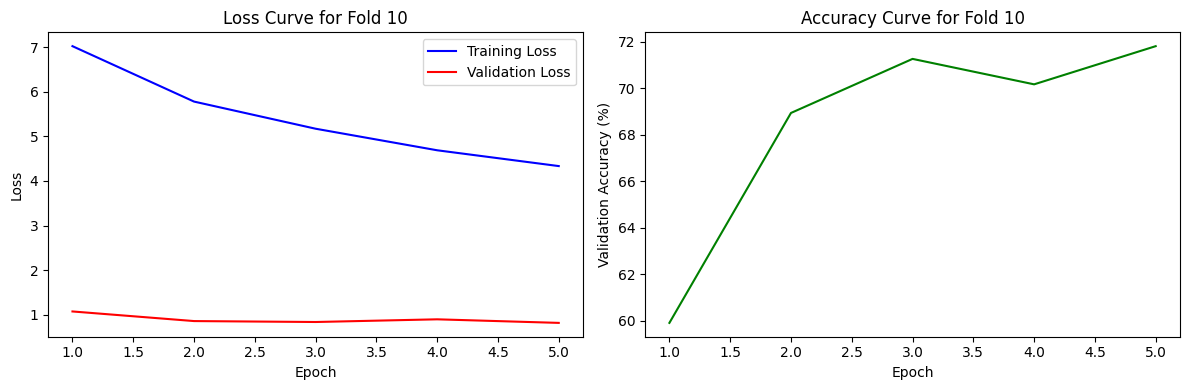

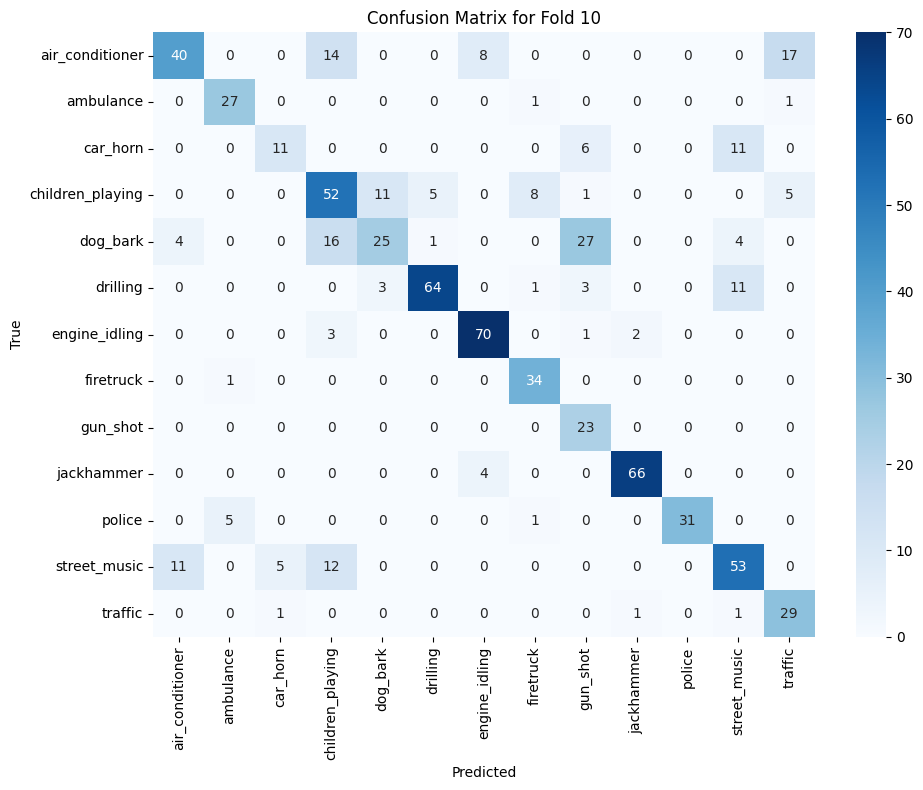

In [26]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(pd.read_csv("/content/spectrograms_balanced_no_sirens.csv"), test_size=0.2, random_state=42)
# train_df, valid_tdf = train_test_split(train_df, test_size=0.2, random_state=42)
train_df.to_csv("./spectrograms_balanced.csv")

main(spec_csv = train_df, batch_size = 64, epochs = 5)

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm
from torchvision import transforms

# Assuming MoCo, Classifier, and SpectrogramDataset classes are defined elsewhere

# Inference class for making predictions using a trained model
class SpectrogramClassifier:
    def __init__(self, checkpoint_path, class_names, device=None):
        if device is None:
            self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        else:
            self.device = device

        print(f"Using device: {self.device}")

        # Initialize model components
        backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        backbone.fc = nn.Identity()

        self.moco = MoCo(backbone).to(self.device)
        self.classifier = Classifier(input_dim=2048, num_classes=len(class_names)).to(self.device)
        self.class_names = class_names

        # Load checkpoint
        print(f"Loading checkpoint from {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=self.device)

        self.moco.load_state_dict(checkpoint['moco'])
        self.classifier.load_state_dict(checkpoint['classifier'])

        # Set to evaluation mode
        self.moco.eval()
        self.classifier.eval()

        # Define transforms (similar to validation transforms)
        self.transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def predict(self, img_path, verbose=True):
        """
        Predict class for a spectrogram image
        Args:
            img_path: Path to the spectrogram image
            verbose: Whether to print detailed information
        Returns:
            Class name, probability, and all class probabilities
        """
        # Load and transform the image
        img = Image.open(img_path).convert('RGB')
        img_tensor = self.transform(img).unsqueeze(0).to(self.device)

        # Get prediction
        with torch.no_grad():
            features = self.moco.get_features(img_tensor)
            logits = self.classifier(features)
            probabilities = F.softmax(logits, dim=1)[0]

        # Get predicted class and probability
        pred_idx = torch.argmax(probabilities).item()
        pred_class = self.class_names[pred_idx]
        confidence = probabilities[pred_idx].item() * 100

        if verbose:
            print(f"Prediction: {pred_class}")
            print(f"Confidence: {confidence:.2f}%")

            # Print top-3 predictions
            top3_values, top3_indices = torch.topk(probabilities, 3)
            print("\nTop 3 predictions:")
            for i in range(3):
                idx = top3_indices[i].item()
                prob = top3_values[i].item() * 100
                print(f"{self.class_names[idx]}: {prob:.2f}%")

        return pred_class, confidence, probabilities.cpu().numpy()

# Visualize prediction
def visualize_prediction(probs, img_path, class_names):
    """
    Visualize prediction with the spectrogram image
    Args:
        probs: Numpy array of class probabilities
        img_path: Path to the spectrogram image
        class_names: List of class names
    """
    # Load image
    img = Image.open(img_path).convert('RGB')

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot image
    ax1.imshow(img)
    ax1.set_title('Spectrogram')
    ax1.axis('off')

    # Plot probabilities
    sorted_idx = np.argsort(probs)[::-1]
    top_classes = [class_names[i] for i in sorted_idx[:5]]
    top_probs = [probs[i] * 100 for i in sorted_idx[:5]]

    ax2.barh(top_classes, top_probs, color='skyblue')
    ax2.set_xlabel('Probability (%)')
    ax2.set_title('Top Predictions')
    ax2.set_xlim(0, 100)

    plt.tight_layout()
    plt.show()

# Example function to predict and visualize a test case
def predict_and_visualize(img_path, model_path, class_names):
    """
    Make a prediction for a single image and visualize the result
    """
    # Create classifier
    classifier = SpectrogramClassifier(model_path, class_names)

    # Make prediction
    pred_class, confidence, probs = classifier.predict(img_path)

    # Visualize prediction
    visualize_prediction(probs, img_path, class_names)

# Test Case: Run prediction for a given image
def test_case():
    # Path to the trained model checkpoint and the test image
    model_checkpoint_path = '/content/results_moco_20250404_151233/checkpoint_4.pth.pth'
    test_image_path = 'path_to_test_image.png'

    # List of class names (you should replace this with your actual class names)
    class_names = ['Class1', 'Class2', 'Class3', 'Class4', 'Class5']  # Example class names

    # Run prediction and visualization
    predict_and_visualize(test_image_path, model_checkpoint_path, class_names)

# Run the test case

In [34]:
import pandas as pd
import torch
from tqdm import tqdm

# Assuming you have a SpectrogramClassifier class and other helper functions defined above

def predict_on_dataframe(df, model_path, class_names, image_dir='./spectrograms', save_results=True):
    """
    Predict classes for a set of images using a pre-trained model.

    Args:
        df: DataFrame containing the spectrogram file names and class names
        model_path: Path to the trained model checkpoint
        class_names: List of class names
        image_dir: Directory where spectrogram images are stored
        save_results: Whether to save the predictions to a CSV file

    Returns:
        predictions_df: DataFrame containing the predictions
    """
    # Create a SpectrogramClassifier object
    classifier = SpectrogramClassifier(model_path, class_names)

    # Initialize list to store results
    results = []

    # Iterate through the DataFrame and make predictions
    for _, row in tqdm(df.iterrows(), total=len(df)):
        # Get the spectrogram image and true class
        img_name = row['spec_file_name']
        true_class = row['class']
        fold = row['fold']

        # Full image path
        img_path = f"{image_dir}/fold{fold}/{img_name}"

        # Make prediction
        pred_class, confidence, probs = classifier.predict(img_path, verbose=False)

        # Store the result (class, confidence, probabilities)
        results.append({
            'spec_file_name': img_name,
            'true_class': true_class,
            'pred_class': pred_class,
            'confidence': confidence,
            'probabilities': probs.tolist()  # Convert tensor to list for saving
        })

    # Create DataFrame with predictions
    predictions_df = pd.DataFrame(results)

    # Optionally, save the results to a CSV file
    if save_results:
        predictions_df.to_csv('predictions.csv', index=False)

    return predictions_df

# Example usage
if __name__ == "__main__":

    class_names  = ['air_conditioner', 'ambulance', 'car_horn', 'children_playing',
       'dog_bark', 'drilling', 'engine_idling', 'firetruck', 'gun_shot',
       'jackhammer', 'police', 'street_music', 'traffic']  # Add all your classes here

    # Path to the trained model checkpoint
    model_checkpoint_path = '/content/results_moco_20250404_151233/checkpoint_4.pth'  # Replace with your model checkpoint path

    # Run predictions on the DataFrame
    predictions_df = predict_on_dataframe(test_df, model_checkpoint_path, class_names)
        # Optionally print or inspect results
    print(predictions_df.head())

Using device: cuda:0
Loading checkpoint from /content/results_moco_20250404_151233/checkpoint_4.pth


100%|██████████| 11584/11584 [03:54<00:00, 49.41it/s]


          spec_file_name       true_class       pred_class  confidence  \
0       159708-6-ts0.png         gun_shot         gun_shot   31.853902   
1  7798623703-10-sa1.png        ambulance        ambulance   46.556032   
2  7803268688-13-ts1.png          traffic          traffic   86.974007   
3        62837-7-sa1.png       jackhammer       jackhammer   57.036418   
4        177621-0-n0.png  air_conditioner  air_conditioner   68.861002   

                                       probabilities  
0  [0.011197090148925781, 0.016945891082286835, 0...  
1  [0.00248927716165781, 0.46556031703948975, 0.0...  
2  [0.0005286780651658773, 0.00012442276056390256...  
3  [0.04948700964450836, 1.5192769751593005e-05, ...  
4  [0.6886100172996521, 0.00012118466111132875, 0...  


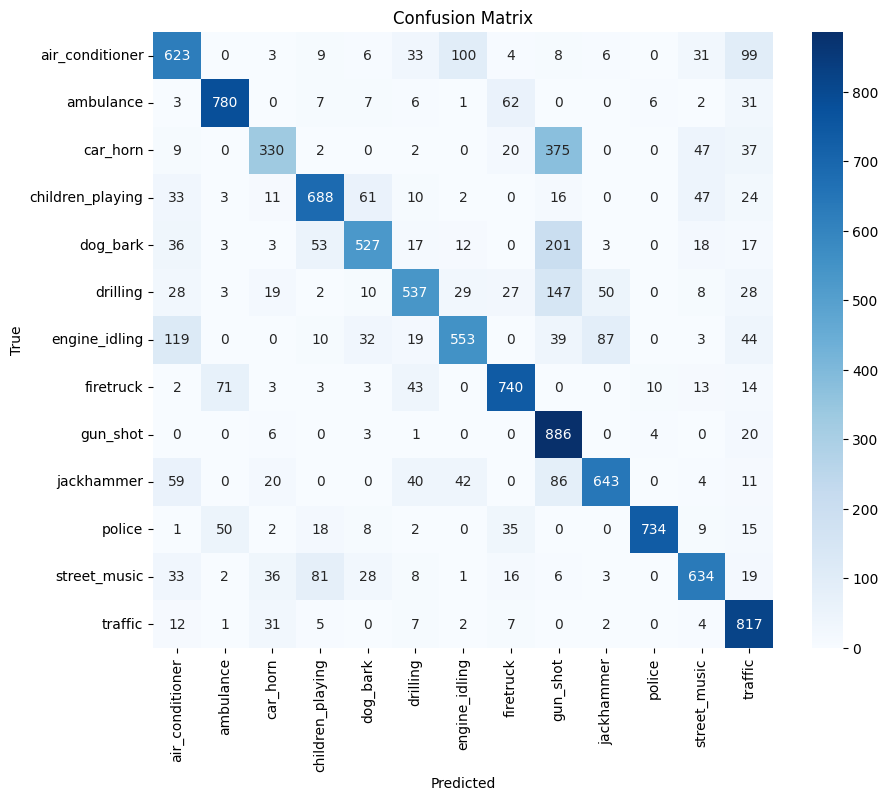

In [35]:
def plot_confusion_matrix(predictions_df, class_names):
    """
    Plot confusion matrix from predictions DataFrame.

    Args:
        predictions_df: DataFrame containing true and predicted classes
        class_names: List of class names
    """
    # Extract true and predicted labels from the DataFrame
    true_labels = predictions_df['true_class']
    pred_labels = predictions_df['pred_class']

    # Generate confusion matrix
    cm = confusion_matrix(true_labels, pred_labels, labels=class_names)

    # Plot confusion matrix using seaborn heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


plot_confusion_matrix(predictions_df, class_names)

In [42]:
def calculate_top_n_accuracy_per_class(predictions_df, top_percent=1):
    """
    Calculate Top N% accuracy for each class based on maximum probabilities.

    Args:
        predictions_df: DataFrame containing predictions with 'pred_class', 'true_class', and 'probabilities' columns
        top_percent: The percentage (1, 5, 10) for Top N% accuracy

    Returns:
        DataFrame containing the Top N% accuracy for each class
    """
    top_n_accuracy = []

    # Group by class and calculate Top N% accuracy for each class
    for class_name, group in predictions_df.groupby('true_class'):
        # Number of samples for this class
        class_size = len(group)

        # Calculate how many samples to select for the top N% (round to nearest integer)
        top_n_count = max(1, int(class_size * top_percent / 100))  # At least one item

        # Sort by max probability in descending order
        group['max_prob'] = group['probabilities'].apply(lambda x: max(x))
        top_n_group = group.nlargest(top_n_count, 'max_prob')

        # Calculate the accuracy (how many predictions in the top N% are correct)
        correct_predictions = (top_n_group['pred_class'] == top_n_group['true_class']).sum()
        accuracy = correct_predictions / top_n_count * 100  # Convert to percentage

        # Append result to the list
        top_n_accuracy.append({
            'Class': class_name,
            f'Top {top_percent}% Accuracy': f"{accuracy:.2f}%"
        })

    # Create a DataFrame for results
    accuracy_df = pd.DataFrame(top_n_accuracy)

    # Sort by Class name if needed
    accuracy_df = accuracy_df.sort_values(by='Class', ascending=True)

    return accuracy_df

# Example usage
# Let's calculate Top 5% Accuracy
top_5_accuracy_df = calculate_top_n_accuracy_per_class(predictions_df, top_percent=5)

# Display the result for Top 5% Accuracy
print(top_5_accuracy_df.to_string(index=False))

# Similarly, you can compute for Top 10% if needed
top_10_accuracy_df = calculate_top_n_accuracy_per_class(predictions_df, top_percent=10)
print(top_10_accuracy_df.to_string(index=False))


           Class Top 5% Accuracy
 air_conditioner          82.61%
       ambulance         100.00%
        car_horn         100.00%
children_playing         100.00%
        dog_bark          97.73%
        drilling         100.00%
   engine_idling          80.00%
       firetruck         100.00%
        gun_shot         100.00%
      jackhammer         100.00%
          police         100.00%
    street_music         100.00%
         traffic         100.00%
           Class Top 10% Accuracy
 air_conditioner           81.52%
       ambulance          100.00%
        car_horn           98.78%
children_playing           98.88%
        dog_bark           98.88%
        drilling          100.00%
   engine_idling           83.33%
       firetruck          100.00%
        gun_shot          100.00%
      jackhammer          100.00%
          police          100.00%
    street_music          100.00%
         traffic          100.00%


In [70]:
import kagglehub

store = kagglehub.dataset_download("mmoreaux/audio-cats-and-dogs")

In [80]:
import librosa
df_extra=pd.read_csv(store+'/train_test_split.csv')
# sample =df_extra[df_extra['test_dog'] == 'dog_barking_97.wav']

def wav_to_spectrogram(wav_file, output_image_file="spectrogram.png"):
    """
    Convert a WAV file into a spectrogram image.

    Args:
        wav_file (str): Path to the WAV file.
        output_image_file (str): Path to save the output spectrogram image (default is "spectrogram.png").
    """
    y, sr = librosa.load(wav_file, sr=None)

    D = librosa.stft(y)

    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_db, x_axis='time', y_axis='log', sr=sr)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')

    plt.savefig(output_image_file, bbox_inches='tight')
    plt.close()

    # print(f"Spectrogram saved as {output_image_file}")


# wav_to_spectrogram(path+'/cats_dogs/'+sample['test_dog'][0], 'dog_bark.png')
paths =df_extra['test_dog'].dropna().apply(lambda x: store+'/cats_dogs/'+x)
extra_paths = []
for i,path in enumerate(paths.items()):
  wav_to_spectrogram(path[1], 'extra/dog_bark_'+str(i)+'.png')
  extra_paths.append('extra/dog_bark_'+str(i)+'.png')

In [54]:
classifier = SpectrogramClassifier('/content/results_moco_20250404_151233/checkpoint_4.pth', class_names)

classifier.predict('dog_bark.png')

Using device: cuda:0
Loading checkpoint from /content/results_moco_20250404_151233/checkpoint_4.pth
Prediction: dog_bark
Confidence: 68.74%

Top 3 predictions:
dog_bark: 68.74%
air_conditioner: 10.17%
engine_idling: 4.94%


('dog_bark',
 68.73682737350464,
 array([1.0169032e-01, 2.4190920e-03, 1.3949105e-03, 2.8774863e-02,
        6.8736827e-01, 2.4043910e-02, 4.9410354e-02, 6.0595102e-03,
        4.0141411e-02, 4.9406249e-02, 1.5089385e-03, 7.7549266e-03,
        2.7297872e-05], dtype=float32))

In [87]:
true_labels = []
pred_labels = []

# Iterate over each path in extra_paths
for p in extra_paths:
    # Get the predicted class and probability from the classifier
    class_name = classifier.predict(p)[0]
    prob = classifier.predict(p)[1]

    # Get the true label from the path-to-label mapping
    true_class = 'dog_bark'  # Assuming each path has a corresponding true label

    # Append to the lists
    true_labels.append(true_class)
    pred_labels.append(class_name)

    # Optionally, print the class name and its predicted probability
    print(f"Predicted: {class_name}, True: {true_class}, Probability: {prob}")

# Now calculate the confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=class_names)

Prediction: dog_bark
Confidence: 68.74%

Top 3 predictions:
dog_bark: 68.74%
air_conditioner: 10.17%
engine_idling: 4.94%
Prediction: dog_bark
Confidence: 68.74%

Top 3 predictions:
dog_bark: 68.74%
air_conditioner: 10.17%
engine_idling: 4.94%
Predicted: dog_bark, True: dog_bark, Probability: 68.73682737350464
Prediction: dog_bark
Confidence: 34.35%

Top 3 predictions:
dog_bark: 34.35%
jackhammer: 13.29%
air_conditioner: 11.50%
Prediction: dog_bark
Confidence: 34.35%

Top 3 predictions:
dog_bark: 34.35%
jackhammer: 13.29%
air_conditioner: 11.50%
Predicted: dog_bark, True: dog_bark, Probability: 34.34613049030304
Prediction: dog_bark
Confidence: 86.72%

Top 3 predictions:
dog_bark: 86.72%
gun_shot: 6.00%
children_playing: 2.69%
Prediction: dog_bark
Confidence: 86.72%

Top 3 predictions:
dog_bark: 86.72%
gun_shot: 6.00%
children_playing: 2.69%
Predicted: dog_bark, True: dog_bark, Probability: 86.71521544456482
Prediction: dog_bark
Confidence: 71.79%

Top 3 predictions:
dog_bark: 71.79%
c

Confusion Matrix:
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 3 13  3  6 12  1  0  2  0  1  6  2  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0]]


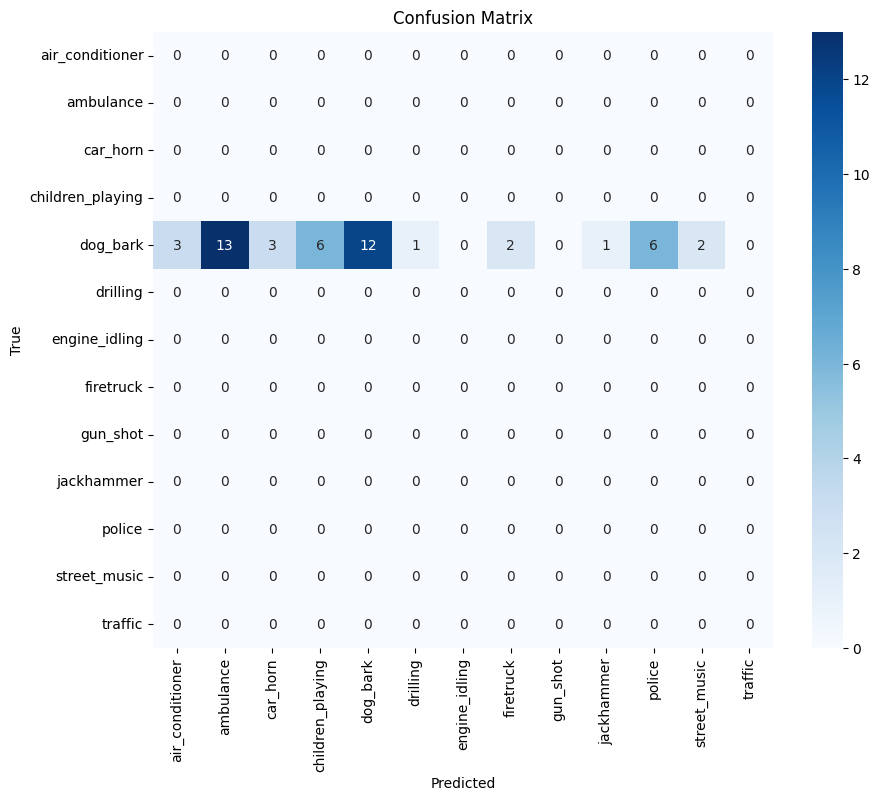


Classification Report:


In [89]:
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Optionally, print the classification report
print("\nClassification Report:")